<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Check-pulse-shape" data-toc-modified-id="Check-pulse-shape-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check pulse shape</a></span></li><li><span><a href="#Check-coupling" data-toc-modified-id="Check-coupling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check coupling</a></span></li><li><span><a href="#Static-Hamiltonian" data-toc-modified-id="Static-Hamiltonian-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Static Hamiltonian</a></span></li><li><span><a href="#Driving-Hamiltonian" data-toc-modified-id="Driving-Hamiltonian-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Driving Hamiltonian</a></span></li><li><span><a href="#Dynamics-analysis" data-toc-modified-id="Dynamics-analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dynamics analysis</a></span></li><li><span><a href="#Tomography" data-toc-modified-id="Tomography-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Tomography</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Optimization</a></span><ul class="toc-item"><li><span><a href="#Optimize-amplitude" data-toc-modified-id="Optimize-amplitude-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Optimize amplitude</a></span></li><li><span><a href="#Optimize-with-DRAG" data-toc-modified-id="Optimize-with-DRAG-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Optimize with DRAG</a></span></li><li><span><a href="#Optimize-with-DRAG-+-detuning" data-toc-modified-id="Optimize-with-DRAG-+-detuning-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Optimize with DRAG + detuning</a></span></li><li><span><a href="#Optimize-with-pulse-rise-time" data-toc-modified-id="Optimize-with-pulse-rise-time-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Optimize with pulse rise time</a></span></li><li><span><a href="#Optimize-with-DRAG-+-rise-time" data-toc-modified-id="Optimize-with-DRAG-+-rise-time-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Optimize with DRAG + rise time</a></span></li></ul></li><li><span><a href="#Sweep-parameters" data-toc-modified-id="Sweep-parameters-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sweep parameters</a></span><ul class="toc-item"><li><span><a href="#Sweep-amplitude,-find-gate-rate" data-toc-modified-id="Sweep-amplitude,-find-gate-rate-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Sweep amplitude, find gate rate</a></span></li><li><span><a href="#Sweep-detuning,-find-gate-rate" data-toc-modified-id="Sweep-detuning,-find-gate-rate-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Sweep detuning, find gate rate</a></span></li><li><span><a href="#Sweep-rise-time,-find-optimal-drive-amplitude" data-toc-modified-id="Sweep-rise-time,-find-optimal-drive-amplitude-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Sweep rise time, find optimal drive amplitude</a></span></li><li><span><a href="#Sweep-coupling-strength,-find-optimal-drive-amplitude" data-toc-modified-id="Sweep-coupling-strength,-find-optimal-drive-amplitude-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Sweep coupling strength, find optimal drive amplitude</a></span></li><li><span><a href="#Sweep-detuning,-find-fidelity,-vary-gate-time" data-toc-modified-id="Sweep-detuning,-find-fidelity,-vary-gate-time-9.5"><span class="toc-item-num">9.5&nbsp;&nbsp;</span>Sweep detuning, find fidelity, vary gate time</a></span></li><li><span><a href="#Sweep-detuning,-find-fidelity,-vary-qubit-qubit-coupling" data-toc-modified-id="Sweep-detuning,-find-fidelity,-vary-qubit-qubit-coupling-9.6"><span class="toc-item-num">9.6&nbsp;&nbsp;</span>Sweep detuning, find fidelity, vary qubit-qubit coupling</a></span><ul class="toc-item"><li><span><a href="#Subplot" data-toc-modified-id="Subplot-9.6.1"><span class="toc-item-num">9.6.1&nbsp;&nbsp;</span>Subplot</a></span></li></ul></li></ul></li></ul></div>

# Preamble

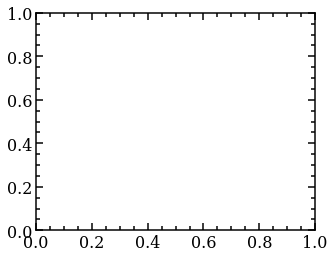

In [2]:
import numpy as np
from qutip import*
from matplotlib import pyplot as plt
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as evol_gates
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
import scipy.linalg
from datetime import datetime
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from qutip.qip.operations import*
from matplotlib import rcParams
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

# Check pulse shape

1.0


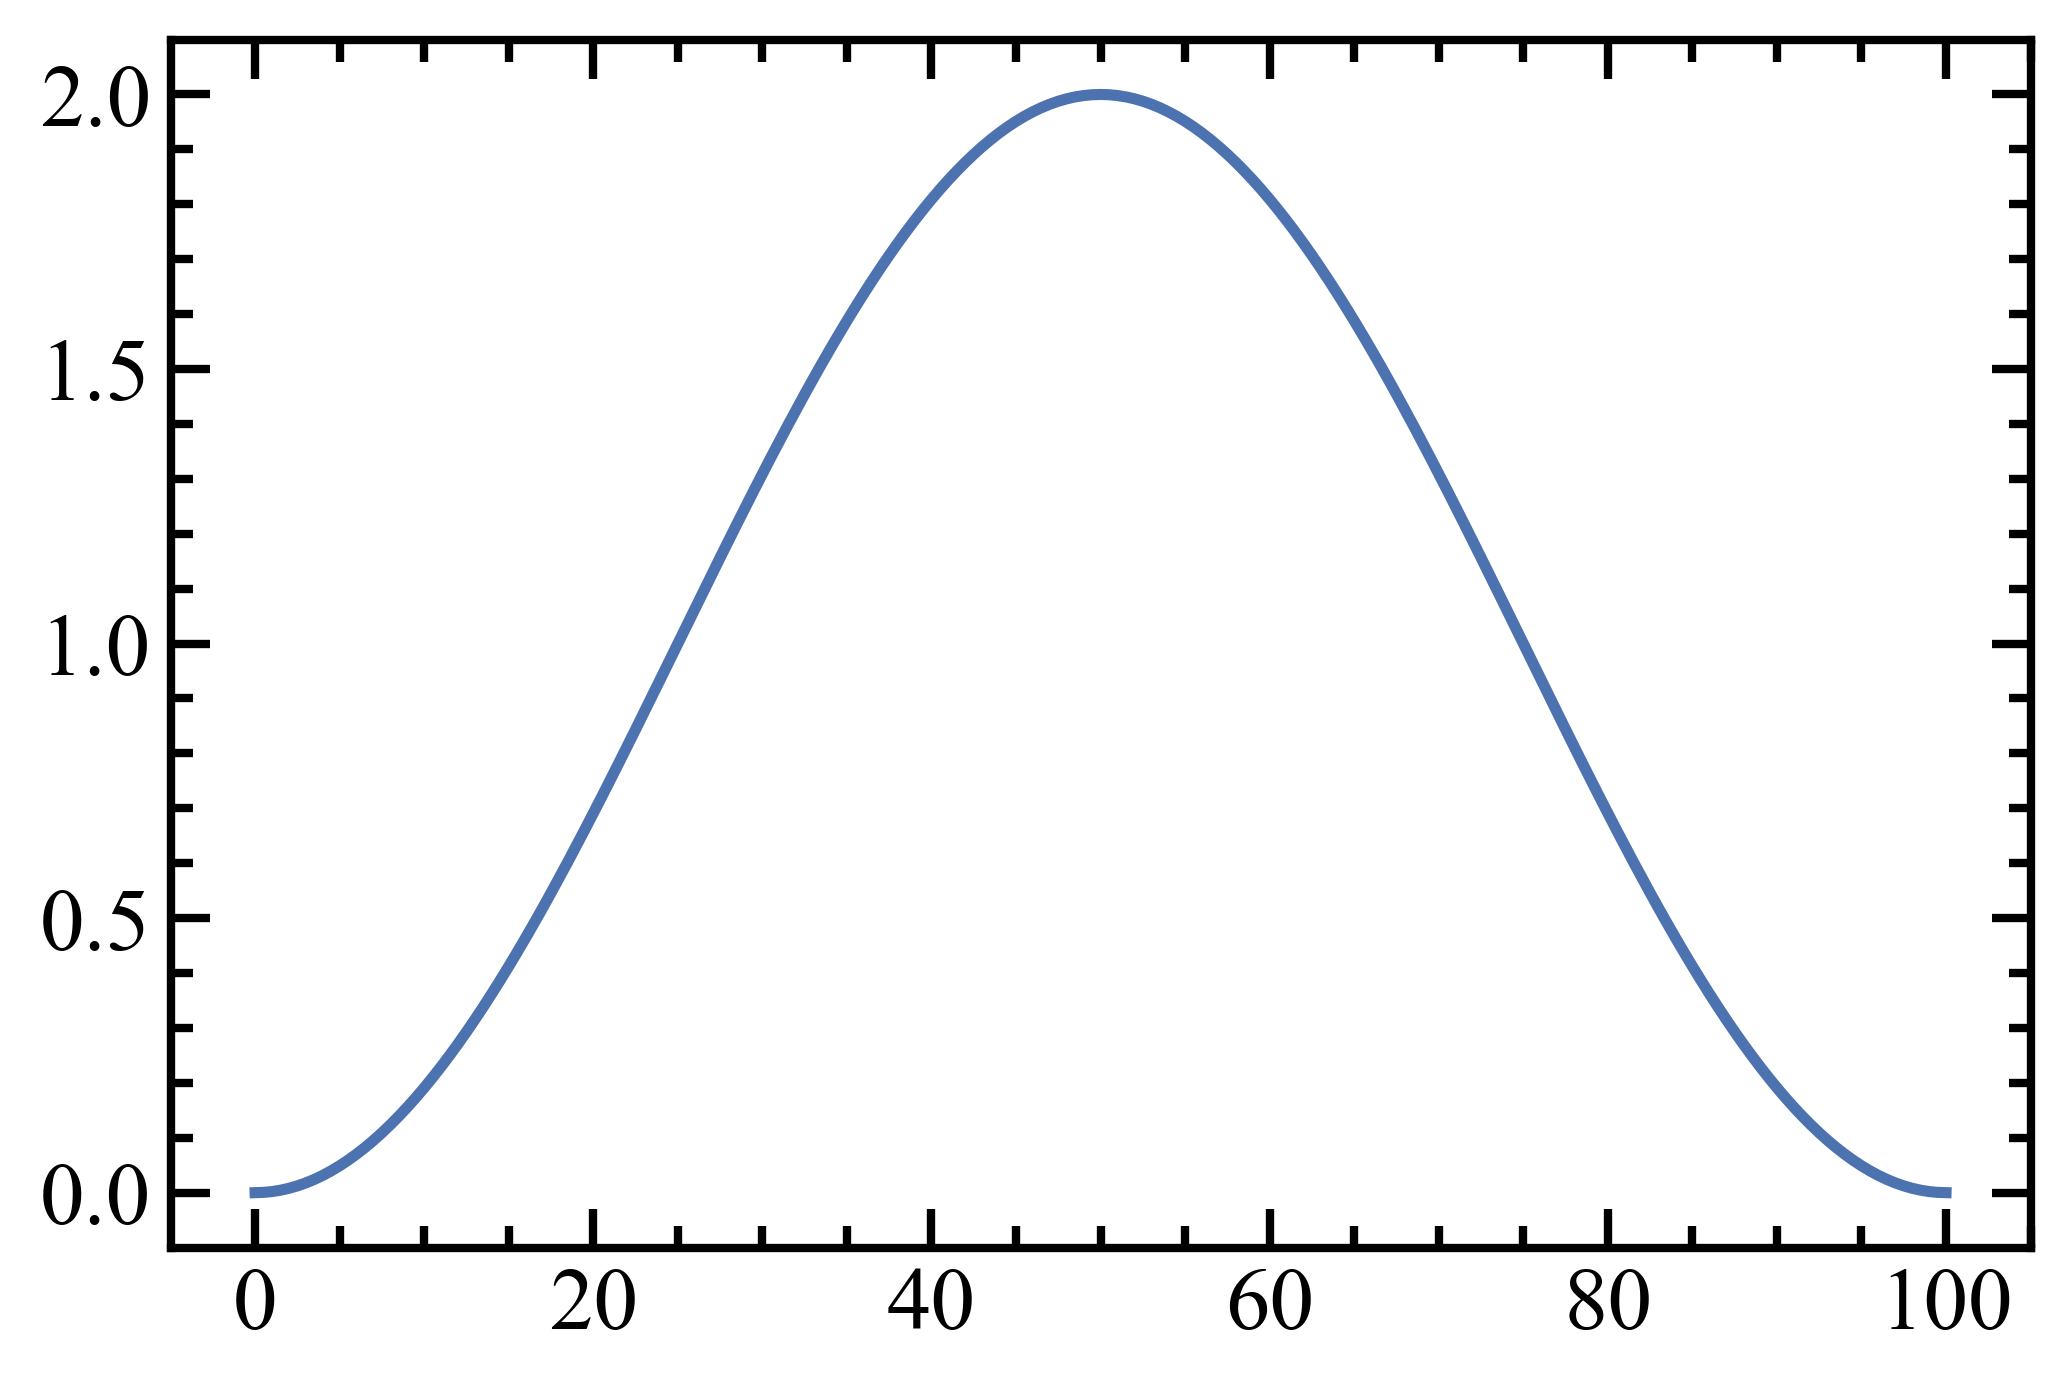

In [37]:
#cosine
T_gate = 100
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
y=(1 - np.cos(2*np.pi*t_points / T_gate))
plt.plot(t_points,y)
area = np.trapz(y,dx=t_points[-1]-t_points[-2])
print (area/T_gate)


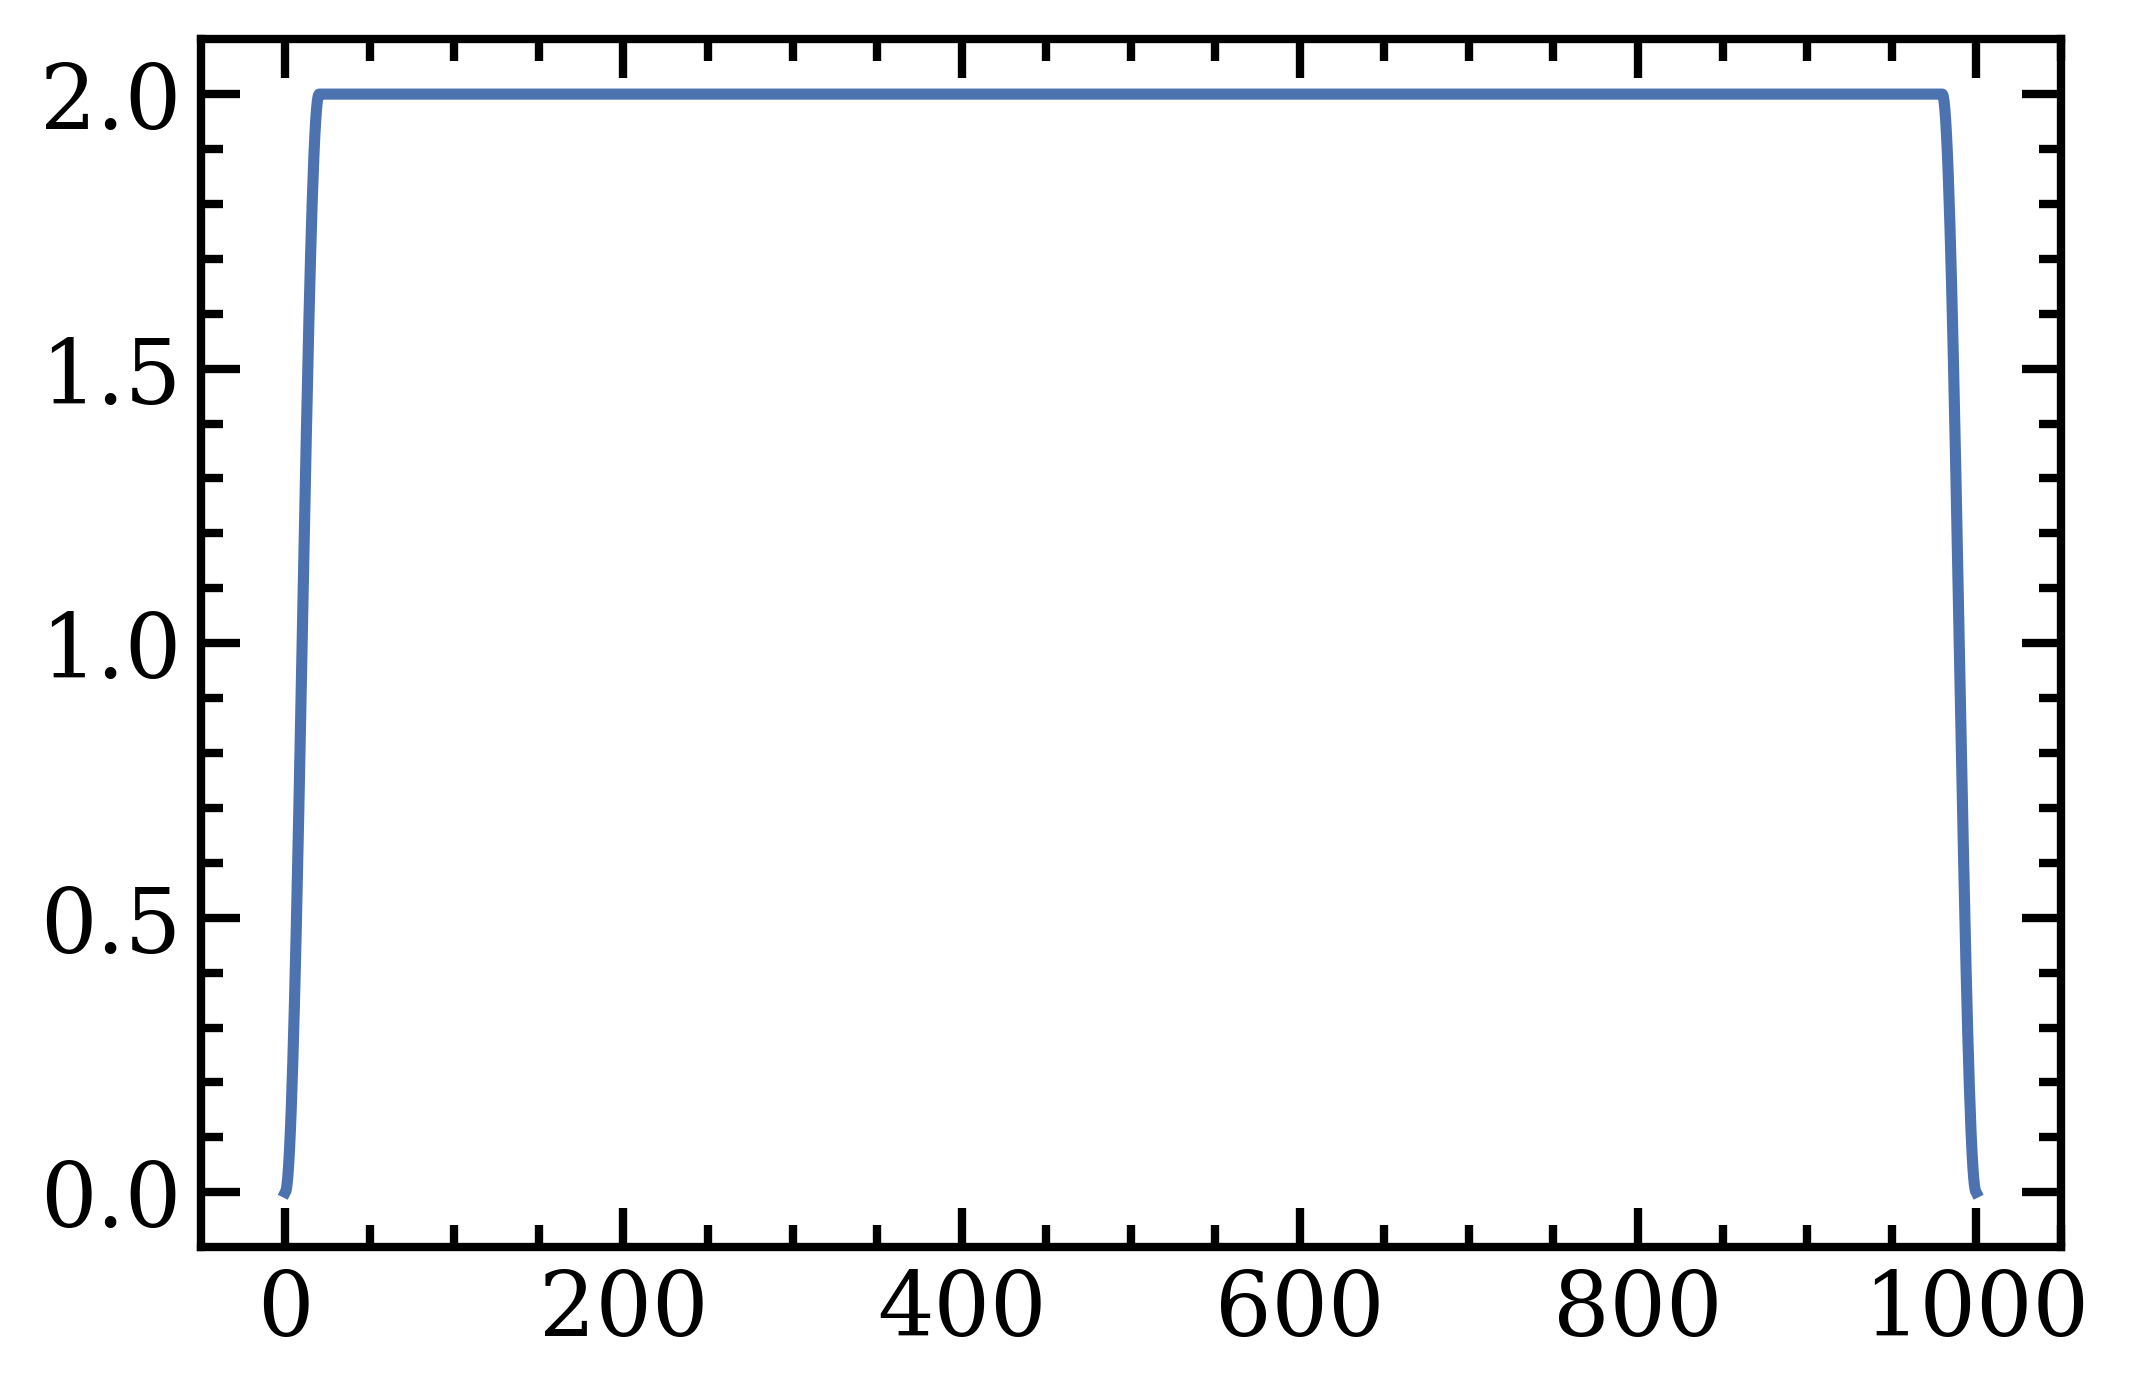

In [4]:
# Cosine flat top
T_start = 0
T_gate = 1000
sigma = 0.25
T_rise = 20

T_left = T_start + T_rise
T_right = T_start + T_gate - T_rise

t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
xi_x = np.zeros_like(t_points)
alpha = 0
xi_x = np.zeros_like(t_points)
xi_y = np.zeros_like(t_points)
# Without shift and normalization.
for idx, t in enumerate(t_points):
    if t < T_left:
        xi_x[idx] = 1+np.cos(2*np.pi*(t - T_left) / T_rise/2)
        xi_y[idx] = alpha * np.sin(2*np.pi*(t - T_left) / T_rise/2)
    elif t > T_right:
        xi_x[idx] = 1+np.cos(2*np.pi*(t - T_right) / T_rise/2)
        xi_y[idx] = -alpha * np.sin(2*np.pi*(t - T_right) / T_rise/2)
    else:
        xi_x[idx] = 2
        xi_y[idx] = 0
plt.plot (t_points, xi_x)

# Check coupling

In [5]:
#Define coupled two-level system Hamiltonian
II = tensor(qeye(2),qeye(2))
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
XI = tensor(sigmax(), qeye(2))
IX = tensor(qeye(2), sigmax())
YI = tensor(sigmay(), qeye(2))
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())

def two_q_hamiltonian(w1, w2, J):
    return -0.5*w1*ZI - 0.5*w2*IZ + J*XX

0.11080779993377766


Text(0.5, 0, '$J$ (MHz)')

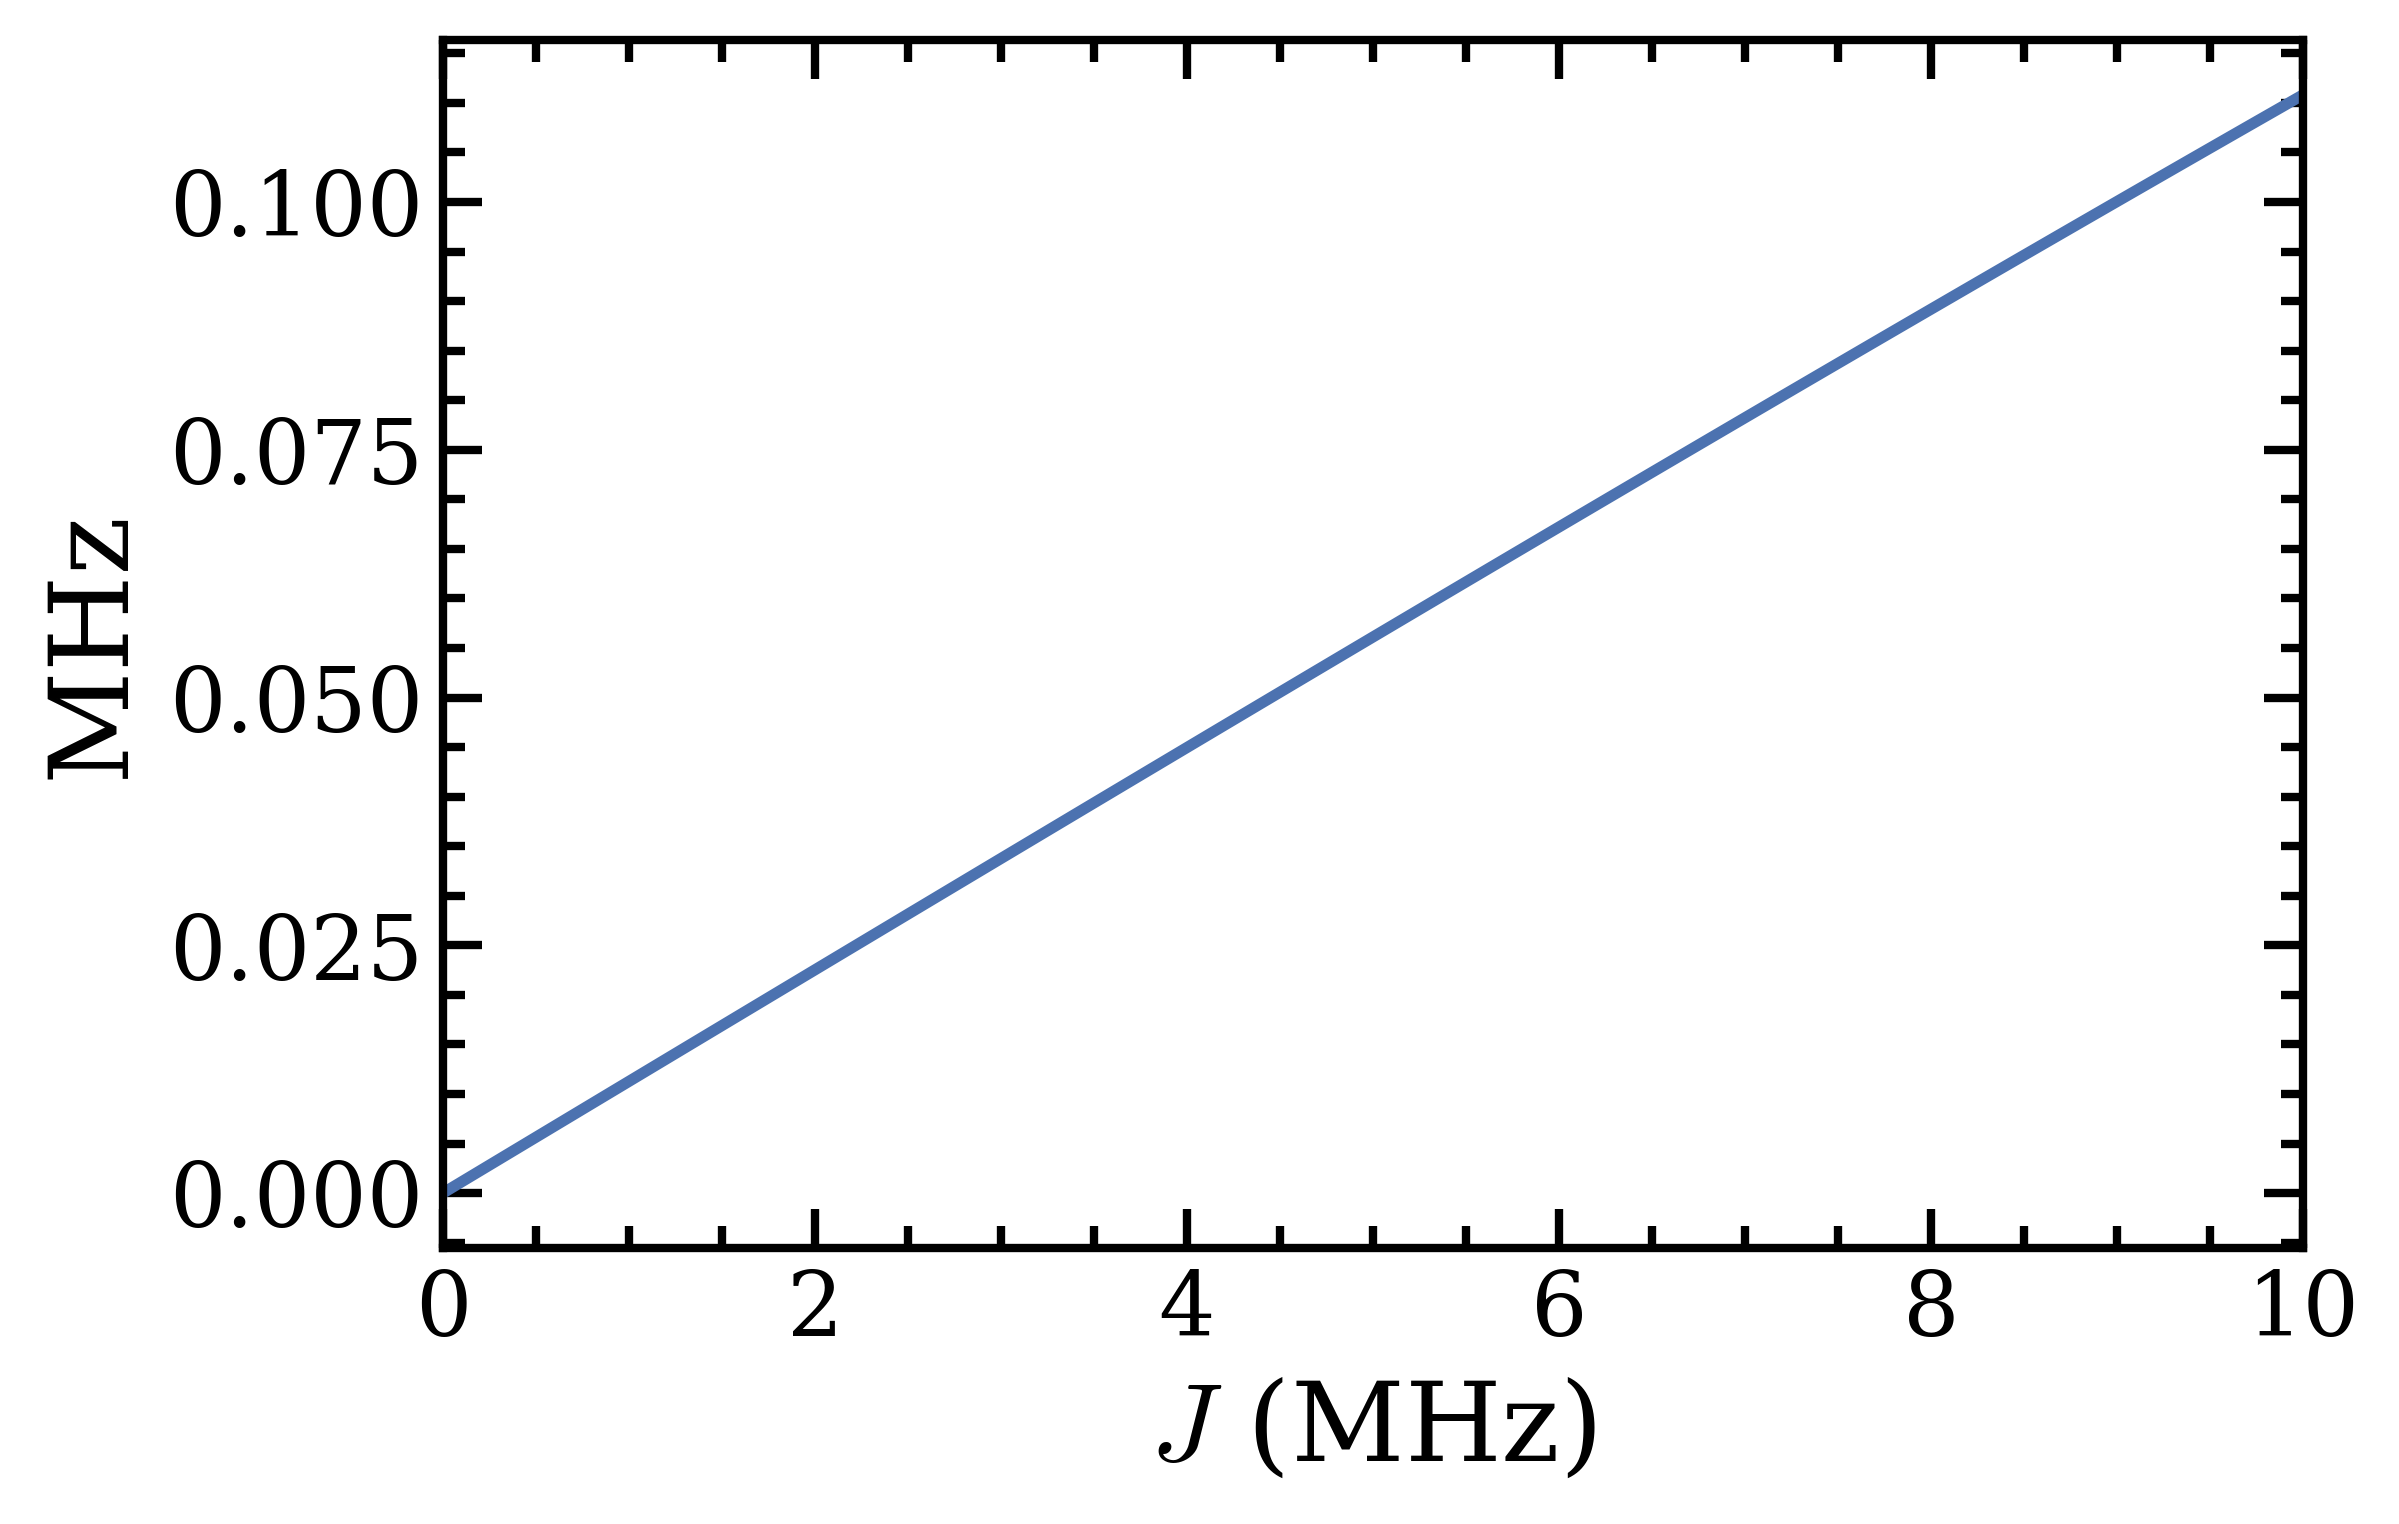

In [6]:
#Qubit frequency
w1 = 0.499
w2 = 0.581

J_array  = np.linspace(0,0.01,101)
freq_shift = np.zeros_like(J_array)
m_element_1 = np.zeros_like(J_array)
m_element_2 = np.zeros_like(J_array)
overlap = np.zeros_like(J_array)
for idx, J in enumerate(J_array):
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates() #System
    freq_shift[idx] = eig_energies[2] - eig_energies[1]
    m_element_1 [idx] = abs(XI.matrix_element(eig_states[1], eig_states[0]))
    m_element_2 [idx] = abs(XI.matrix_element(eig_states[2], eig_states[0]))
#     overlap [idx] = abs(II.matrix_element(eig_states[1], eig_states[2]))
#     overlap [idx] = abs(eig_states[2]*eig_states[1].dag())
freq_shift = freq_shift - 0.1
plt.plot(J_array*1e3, m_element_2/m_element_1)
print (m_element_2[-1]/m_element_1[-1])
plt.xlim([J_array[0]*1e3, J_array[-1]*1e3])
plt.ylabel('MHz')
plt.xlabel(r'$J$ (MHz)')

In [143]:
# plt.plot(J_array*1e3, m_element_sx)
# plt.ylabel(r'$|\langle 00 |X\otimes I|01 \rangle | $')
# plt.xlabel(r'$J$ (MHz)')
# plt.ylim([0,0.05])

plt.plot(J_array*1e3, m_element_sy)
plt.ylabel(r'$|\langle 00 |Y\otimes I|01 \rangle | $')
plt.xlabel(r'$J$ (MHz)')
# plt.ylim([0,0.05])

# plt.plot(J_array*1e3,overlap)

NameError: name 'm_element_sy' is not defined

# Static Hamiltonian

In [178]:
#Qubit frequency
w1 = 0.5
w2 = 0.6

J = 0.02 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

print ((eig_energies[2]-eig_energies[0]) - (eig_energies[3]-eig_energies[1]))
print((eig_states[2].dag()*eig_states[1]))

1.1102230246251565e-16
Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[0.]]


In [181]:
print (eig_states[1])
print (eig_states[2])

print (eig_energies[1])
print (eig_energies[2])

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.18910752]
 [-0.98195639]
 [ 0.        ]]
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.98195639]
 [0.18910752]
 [0.        ]]
-0.05385164807134501
0.05385164807134504


# Driving Hamiltonian

In [151]:
drive_freq = eig_energies[2]-eig_energies[0] #Second qubit frequency

coupl_const = 9.4388785   #Rabi freq in MHz
eta = 0
coupl_const = coupl_const*1e-3*2*np.pi
H1 = coupl_const*(XI+eta*IX) #Driving first qubit only

#Gate parameters
shape = 'cosflattop'
T_start = 0
T_gate = 200
sigma = 0.25
T_rise = T_gate/3.0
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2))*0
U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points = t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
# U_nothing = evol_gates.evolution_operator_microwave_nonorm(-H0,H_dum, t_points = t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
#         T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

# Dynamics analysis

In [41]:
trans_prob_00_00 = expect(state_00 * state_00.dag(),U_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),U_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),U_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),U_t*state_00)

# U_rw = U_nothing*U_t

sx0 = expect(IX,U_t*state_00)
sy0 = expect(IY,U_t*state_00)
sz0 = expect(IZ,U_t*state_00)
sx1 = expect(IX,U_t*state_10)
sy1 = expect(IY,U_t*state_10)
sz1 = expect(IZ,U_t*state_10)

# sx0 = expect(IX,U_t*XI*U_t*state_00)
# sy0 = expect(IY,U_t*XI*U_t*state_00)
# sz0 = expect(IZ,U_t*XI*U_t*state_00)
# sx1 = expect(IX,U_t*XI*U_t*state_10)
# sy1 = expect(IY,U_t*XI*U_t*state_10)
# sz1 = expect(IZ,U_t*XI*U_t*state_10)

# sx0 = expect(IX,U_rw*state_00)
# sy0 = expect(IY,U_rw*state_00)
# sz0 = expect(IZ,U_rw*state_00)
# sx1 = expect(IX,U_rw*state_10)
# sy1 = expect(IY,U_rw*state_10)
# sz1 = expect(IZ,U_rw*state_10)

# plt.plot(t_points, trans_prob_00_00, label = '00')
# plt.plot(t_points, trans_prob_00_01, label = '01')
# plt.plot(t_points, trans_prob_00_10, label = '10')
# plt.plot(t_points, trans_prob_00_11, label = '11')
# plt.plot(t_points, np.cos(2*np.pi*coupl_const*1e-2 * 1e9 *t_points*1e-9))

# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = [10,12])
# ax1.plot(t_points, sx0, label = 'C0')
# ax1.plot(t_points, sx1, label = 'C1')
# ax2.plot(t_points, sy0, label = 'C0')
# ax2.plot(t_points, sy1, label = 'C1')
# ax3.plot(t_points, sz0, label = 'C0')
# ax3.plot(t_points, sz1, label = 'C1')

# ax1.legend()
# ax2.legend()
# ax3.legend()

# plt.xlabel('Time (ns)')
# plt.ylabel(r'$P$')

# b = Bloch()
# b.add_points([sx0, sy0, sz0], meth='l')
# b.make_sphere()
# b = Bloch()
# b.add_points([sx1, sy1, sz1], meth='l')
# b.make_sphere()

200.0
400
0.9687525509410979


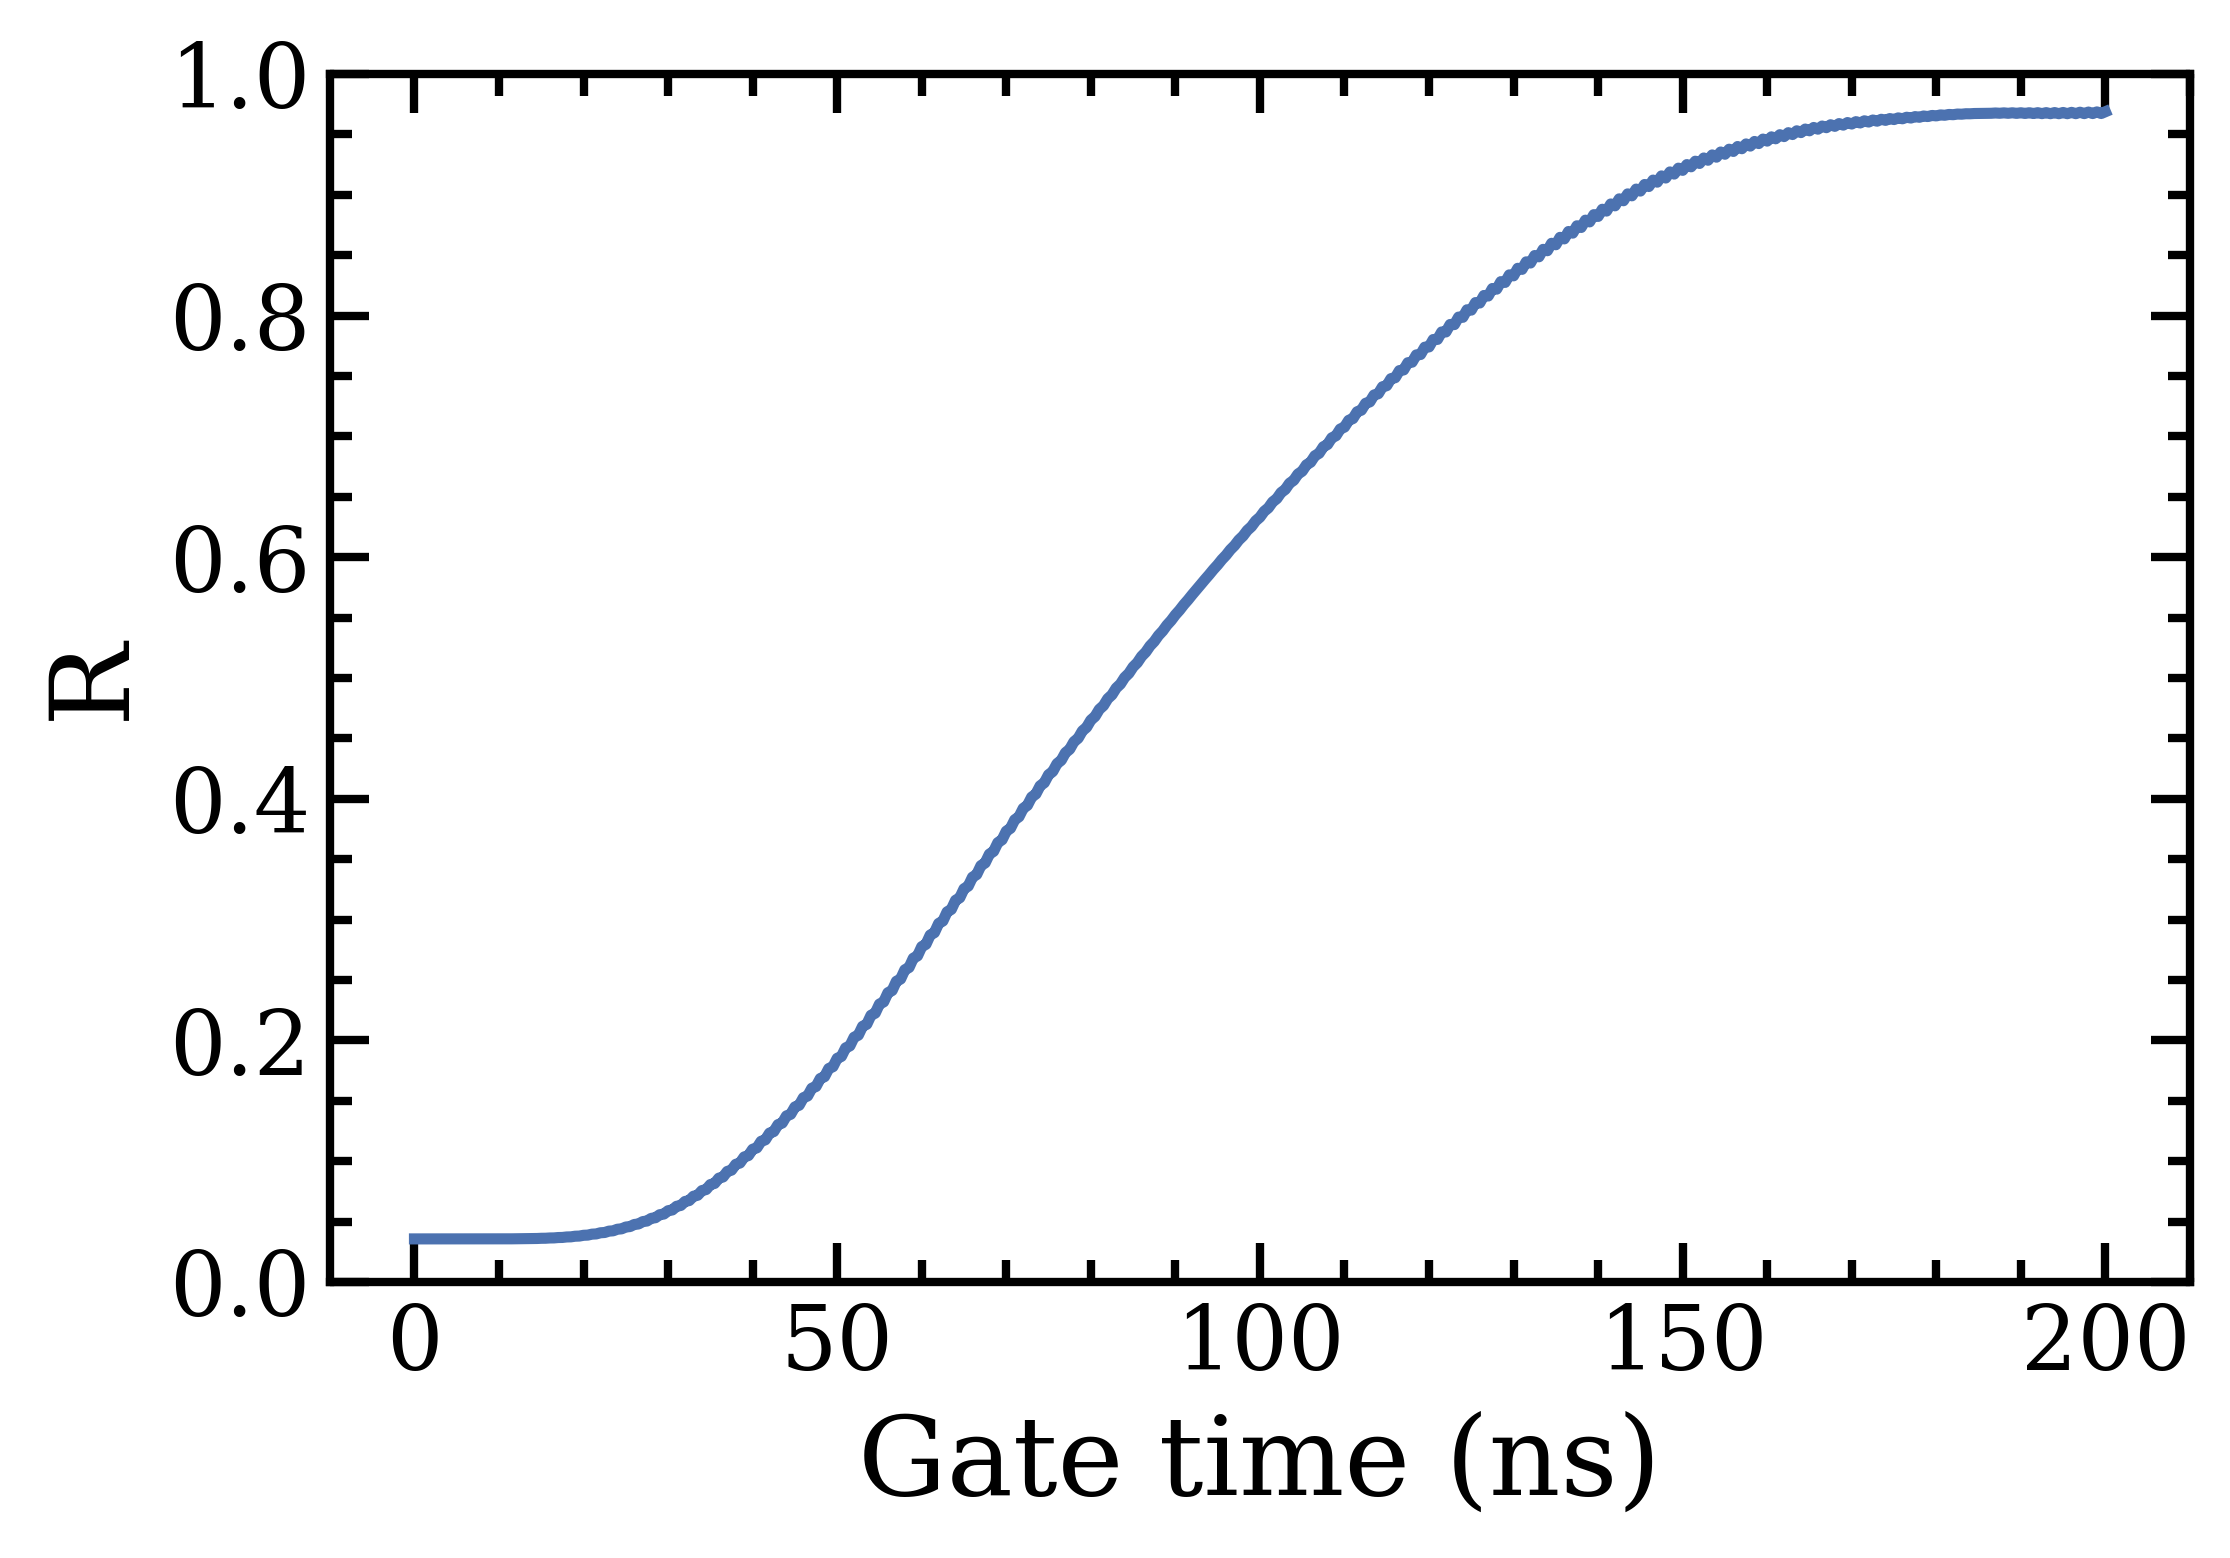

In [42]:
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
plt.plot(t_points, R, label = '0')
plt.ylim([0,1])
plt.xlabel('Gate time (ns)')
plt.ylabel('R')
print (t_points[np.argmax(R)])
print(np.argmax(R))
print (R[-1])

In [43]:
u00 = U_t[-1].matrix_element(state_00.dag(), state_00)
u01 = U_t[-1].matrix_element(state_01.dag(), state_01)
u10 = U_t[-1].matrix_element(state_10.dag(), state_10)
u11 = U_t[-1].matrix_element(state_11.dag(), state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
phasezz = np.angle(u11*u00/(u01*u10))
print(phase1)
print(phase2)
print(phasezz)

single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
# zz_gate = 
U = single_qu_z*U_t[-1]

u00 = U.matrix_element(state_00.dag(), state_00)
u01 = U.matrix_element(state_01.dag(), state_01)
u10 = U.matrix_element(state_10.dag(), state_10)
u11 = U.matrix_element(state_11.dag(), state_11)
phase1 = np.angle(u00*u01/(u10*u11))
phase2 = np.angle(u00*u10/(u01*u11))
print(phase1)
print(phase2)
print (np.round(np.real(U),2))

-2.554099684212686
2.839770835517673
0.0
-4.5430888076642555e-17
9.086177615328518e-17
[[ 0.76 -0.09 -0.02  0.  ]
 [-0.09  0.76  0.   -0.02]
 [-0.02 -0.    0.76  0.09]
 [-0.   -0.02  0.09  0.76]]


In [44]:
rzx_m = np.diag(np.ones(4, dtype = complex))
rzx_m[0,2] = -1j
rzx_m[1,3] = 1j
rzx_m[2,0] = -1j
rzx_m[3,1] = 1j
rzx_m = rzx_m/ np.sqrt(2)
rzx_m = Qobj(rzx_m)
rzx_m.dims = [[2,2],[2,2]]
print (rzx_m*np.sqrt(2))
print (tensor(qeye(2), rx(-np.pi/2)))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+1.j]
 [0.-1.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 1.+0.j]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.70710678j 0.70710678+0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.j
  0.        +0.70710678j]
 [0.        +0.j         0.        +0.j         0.        +0.70710678j
  0.70710678+0.j        ]]


# Tomography

<ipython-input-45-3ed0005e19dd>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8de65243d0>)

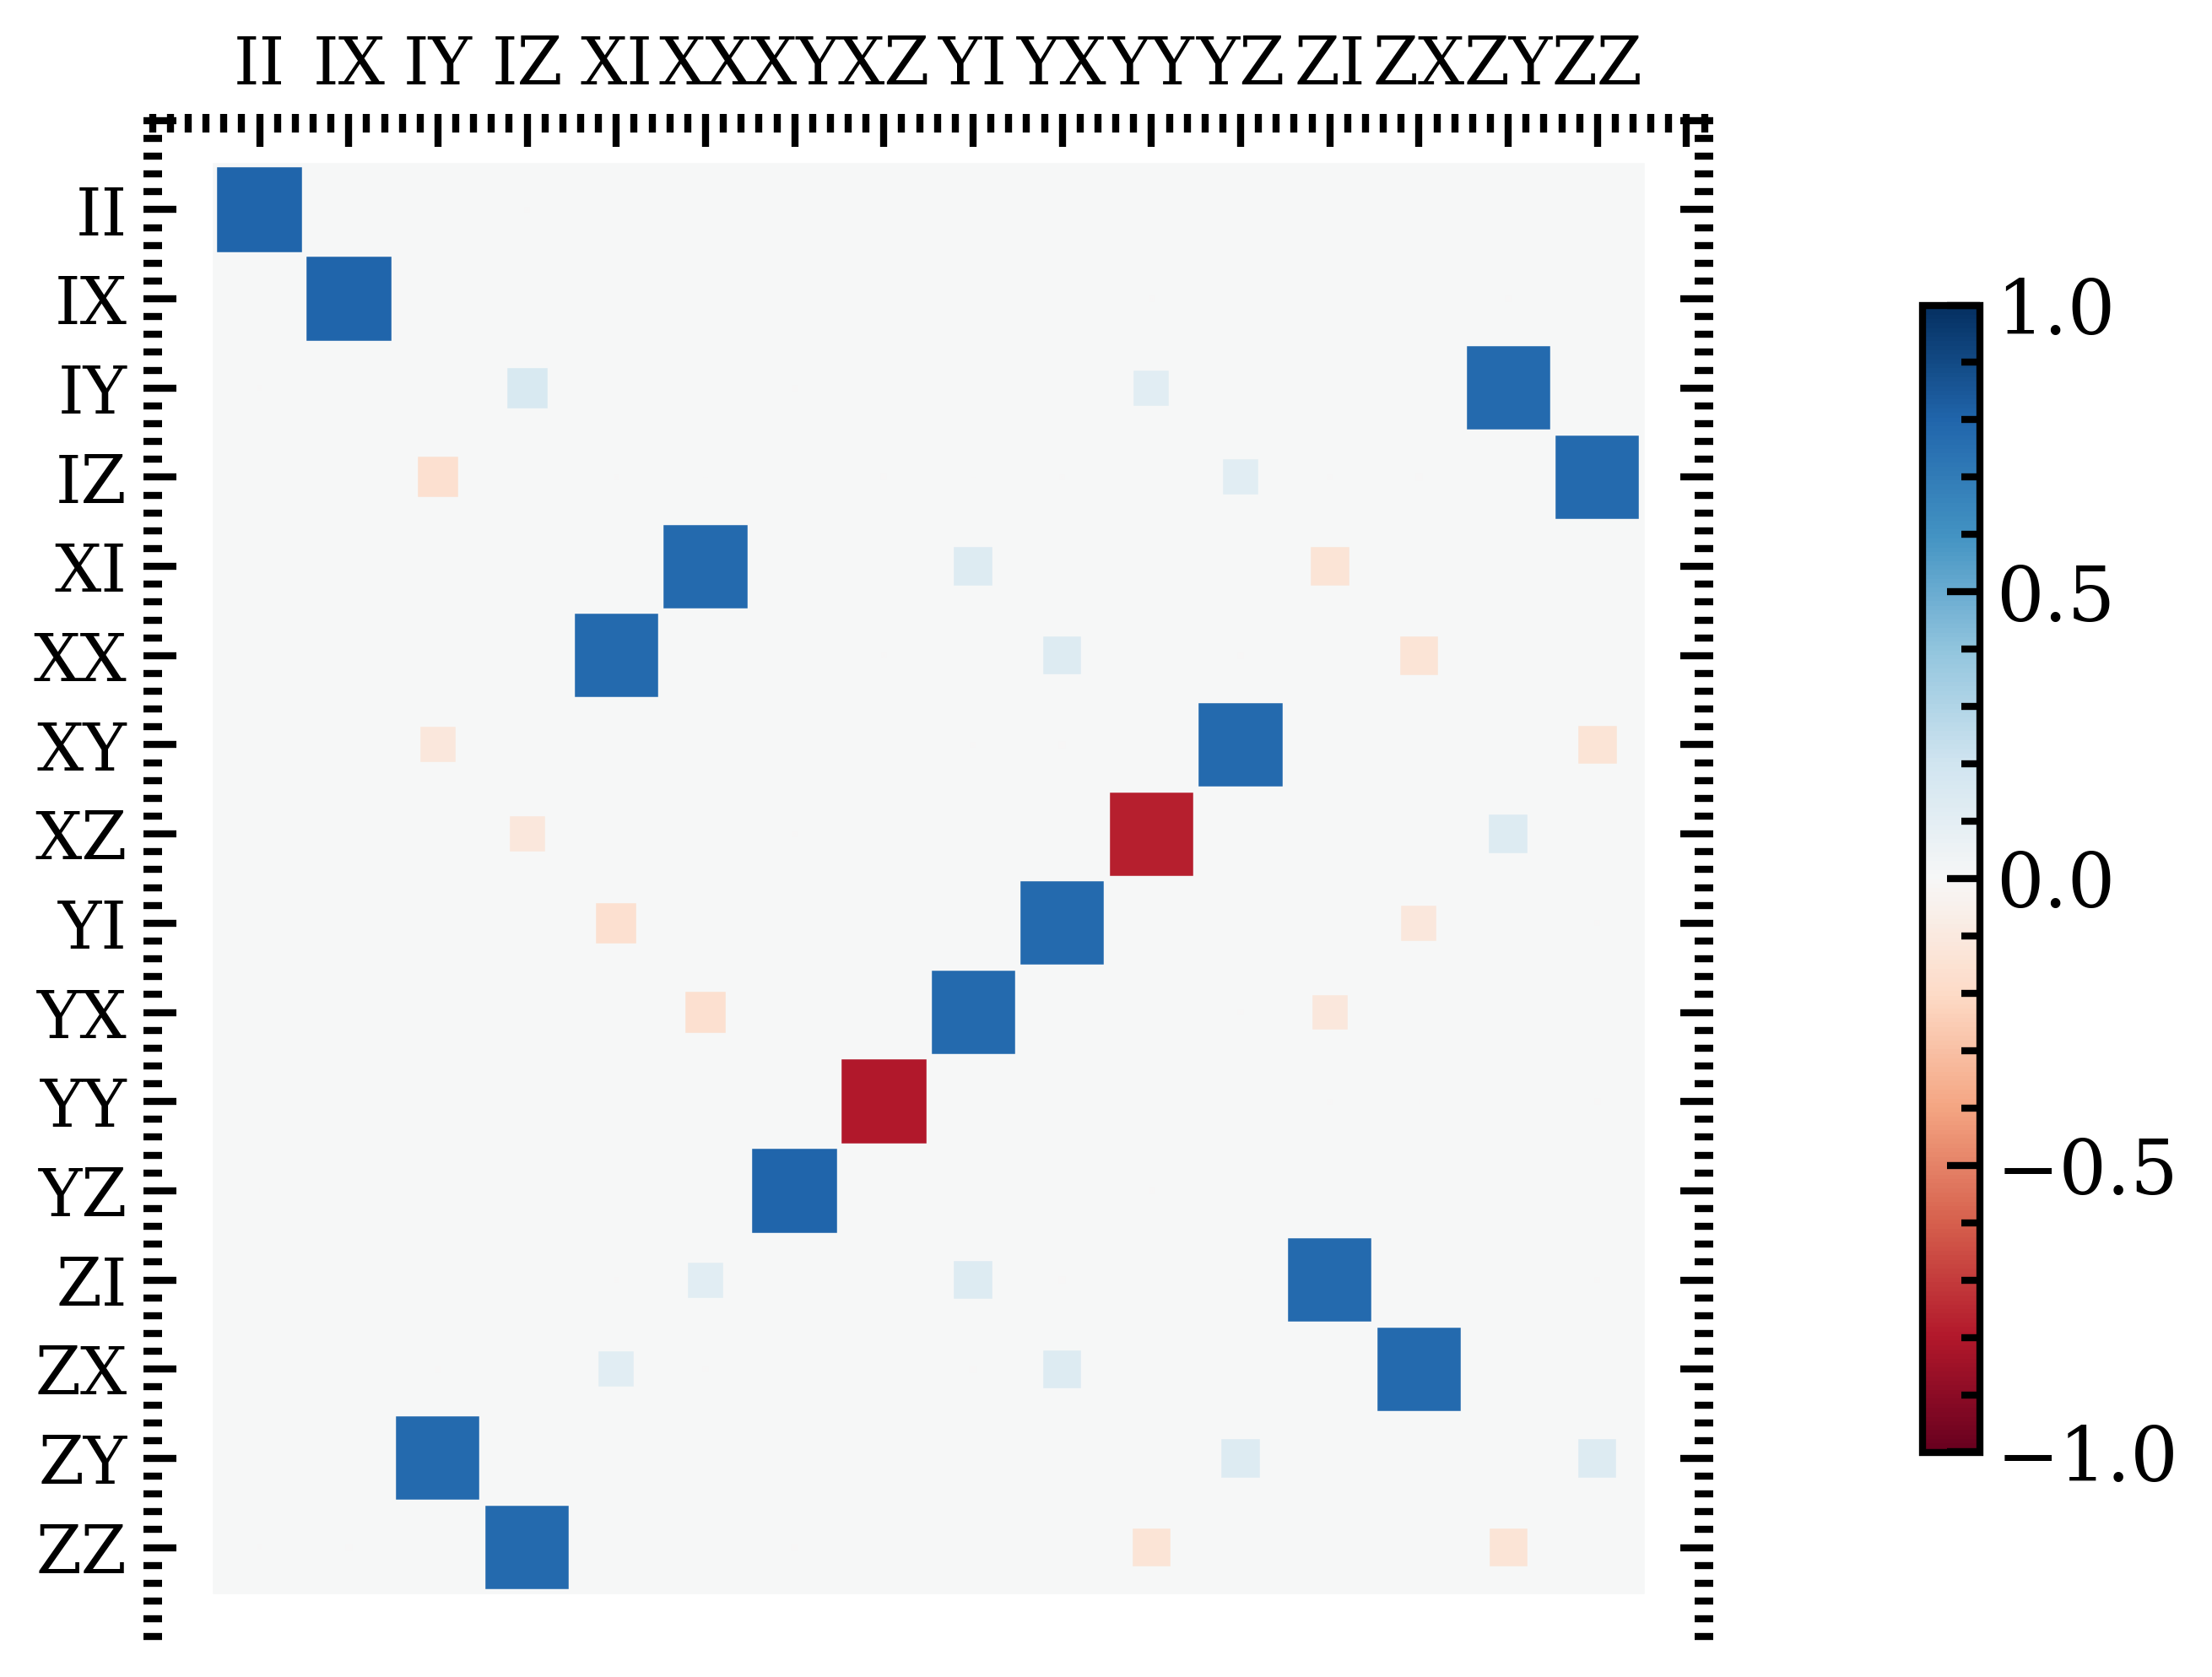

In [45]:
prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16)) 
p_out = np.zeros((16,16)) 

gnd_state = tensor(basis(2,0), basis(2,0))
# gate_op = tensor(qeye(2), rx(np.pi/2))
# gate_op = tensor(rx(np.pi/2), qeye(2))
# gate_op = cnot()
# gate_op = rzx_m
U_Z2I = tensor(rz(-np.pi/2), qeye(2))
U_IX2 = tensor(qeye(2), rx(-np.pi/2))
gate_op = U_Z2I * U * U_IX2
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        p_out[i,j] = expect(rot_j, gate_op*(rot_i*gnd_state))        
ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
# print (op_label)
qutip.hinton(ptm_ideal_2q, xlabels = op_label, ylabels = op_label)


In [46]:
U_ideal = cnot()
U_real = gate_op

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
print (fidel)

0.9825298410833374


# Optimization

## Optimize amplitude

In [27]:
T_start = 0
T_gate = 200
T_rise = 50
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
drag = False
def error(x):
    coupl = x[0]
    eta = 0
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI+eta*IX)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    sx0 = expect(IX,U_t*state_00)
    sy0 = expect(IY,U_t*state_00)
    sz0 = expect(IZ,U_t*state_00)
    sx1 = expect(IX,U_t*state_10)
    sy1 = expect(IY,U_t*state_10)
    sz1 = expect(IZ,U_t*state_10)
    R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
    return 1.0 - R[-1]
    
x0 = [11] #guess
xopt = minimize(error, x0, method ='Powell', tol = None)

print ('Entanglement = ', 1.0-error(xopt.x))
print (xopt.x)

Entanglement =  0.9834790586743827
[9.4388785]


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.01052457]
 [ 0.        ]
 [ 0.        ]
 [-0.99994462]]


In [155]:
U_ideal = eig_states[0]*eig_states[0].dag() + eig_states[2]*eig_states[2].dag() + eig_states[1]*eig_states[3].dag() + eig_states[3]*eig_states[1].dag()
# print (np.round(U_ideal),2)
# U_ideal = cnot()
# print (np.round(U_ideal),2)
shape = 'cosflattop'
T_start = 0
T_gate = 200
T_rise = T_gate/3.0
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
drag = False
drive_freq = eig_energies[2]-eig_energies[0]

U_Z2I = np.exp(1j*np.pi/4)*eig_states[0]*eig_states[0].dag() + np.exp(-1j*np.pi/4)*eig_states[1]*eig_states[1].dag() + np.exp(1j*np.pi/4)*eig_states[2]*eig_states[2].dag() + np.exp(-1j*np.pi/4)*eig_states[3]*eig_states[3].dag()
U_IX2 = np.sqrt(2)**-1*(eig_states[0]*eig_states[0].dag() + eig_states[2]*eig_states[2].dag() + eig_states[1]*eig_states[1].dag() + eig_states[3]*eig_states[3].dag()) \
+ 1.0j*np.sqrt(2)**-1*(eig_states[0]*eig_states[2].dag() + eig_states[2]*eig_states[0].dag() + eig_states[1]*eig_states[3].dag() + eig_states[3]*eig_states[1].dag())


def infidelity(x):
    coupl = x[0]
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    phase0 = np.angle(U_t[-1].matrix_element(eig_states[0].dag(), eig_states[0]))
    phase1 = np.angle(U_t[-1].matrix_element(eig_states[1].dag(), eig_states[1]))
    phase2 = np.angle(U_t[-1].matrix_element(eig_states[2].dag(), eig_states[2]))
    phase3 = np.angle(U_t[-1].matrix_element(eig_states[3].dag(), eig_states[3]))

    single_qu_z = 0
    single_qu_z = single_qu_z + np.exp(-1j*phase0)*eig_states[0]*eig_states[0].dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*eig_states[1]*eig_states[1].dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*eig_states[2]*eig_states[2].dag()
    single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*eig_states[3]*eig_states[3].dag()
    U = single_qu_z*U_t[-1]

    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return abs(1.0-fidel)
    
# x0 = [19] #guess
x0 = [10]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)

print (infidelity(xopt.x))
print (xopt.x)

6.040426336895166e-07
[3.62261963]


## Optimize with DRAG

In [36]:
U_ideal = cnot()
T_start = 0
T_gate = 200
T_rise = T_gate/3.0
drag = True

def infidelity(x):
    coupl = x[0]
    drag_coeff = x[1]
    delta_omega = 0
    coupl_const = coupl*1e-3*2*np.pi
    drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [9,0] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

print ('Fidelity = ', fidelity)
print (xopt.x)

Fidelity =  0.9874082014707792
[1.05319583e+01 4.12057966e-03]


## Optimize with DRAG + detuning

In [58]:
T_start = 0
T_gate = 100
T_rise = 20
drag = True

def infidelity(x):
    coupl = x[0]
    drag_coeff = x[1]
    delta_omega = x[2]
    coupl_const = coupl*1e-3*2*np.pi
    drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [45,0,0] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

print ('Fidelity = ', fidelity)
print (xopt.x)

Fidelity =  0.993892654388717
[ 4.14045074e+01 -7.03628912e-02  6.84980367e-05]


## Optimize with pulse rise time

In [1]:
T_start = 0
T_gate = 200
drag = False
drag_coeff = 0
def infidelity(x):
    coupl = x[0]
    T_rise = x[1]
    delta_omega = 0
    coupl_const = coupl*1e-3*2*np.pi
    drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [18,40] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

print ('Fidelity = ', fidelity)
print (xopt.x)

NameError: name 'minimize' is not defined

## Optimize with DRAG + rise time

In [78]:
T_start = 0
T_gate = 200
drag = True

def infidelity(x):
    coupl = x[0]
    T_rise = x[1]
    drag_coeff = x[2]
    delta_omega = 0
    coupl_const = coupl*1e-3*2*np.pi
    drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [18,40,0] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

print ('Fidelity = ', fidelity)
print (xopt.x)

Fidelity =  0.9962924113097487
[18.03238608 51.58998296  0.05824822]


# Sweep parameters

In [151]:
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

## Sweep amplitude, find gate rate

In [7]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

J = 0.011 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates()

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]

#Gate parameters
drive_freq = eig_energies[2]-eig_energies[0]
T_start = 0
T_gate = 1000
shape = 'square'
drag = False
drag_coeff = 0
t_points = np.linspace(0,T_gate, 10*int(T_gate)+1)
coupl_array = np.linspace(5,200,196)
# print (coupl_array)
sz_amp = np.zeros((len(t_points), len(coupl_array)))

for idx, coupl in enumerate(coupl_array):
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI) #Driving first qubit only
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points = t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, omega_d=drive_freq)
    sz_amp[:,idx] = (expect(IZ,U_t*state_00))
#     print (idx)

[  5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.
  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.
  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102.
 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158.
 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172.
 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186.
 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.]
0
1
2

KeyboardInterrupt: 

In [ ]:
np.save(figpath+'')

In [95]:
def cosine_func(x,amp,freq,c1,c2):
    return amp*np.cos(2*np.pi*freq*(x-c1))+c2

coupl_array = np.linspace(5,200,196)
gate_rate = np.zeros_like(coupl_array)
fit_error = np.zeros_like(coupl_array)

# guess =[1,0.0012,0,0]
# plt.plot(t_points,sz[:,2])
# opt,cov = curve_fit(cosine_func, xdata = t_points, ydata = sz[:,2], p0=guess)
# plt.plot(t_points,cosine_func(t_points, *opt))
# print (opt[1])

for idx, coupl in enumerate(coupl_array):
    if idx ==0:
        freq_guess = 0.001
    else:
        freq_guess = gate_rate[idx-1]
    guess =[1,freq_guess,0,0]
    opt,cov = curve_fit(cosine_func, xdata = t_points, ydata = sz_amp[:,idx], p0=guess,maxfev = 100000)
    gate_rate[idx] = opt[1]
    fit_error[idx] = np.sqrt(np.diag(cov))[1]
coupl_array = np.insert(coupl_array,0,0) 
gate_rate=np.insert(gate_rate,0,0) 
np.save(figpath+'/CR_amp_vs_rate_TLS.npy',gate_rate)

ValueError: operands could not be broadcast together with shapes (4001,) (10001,) 

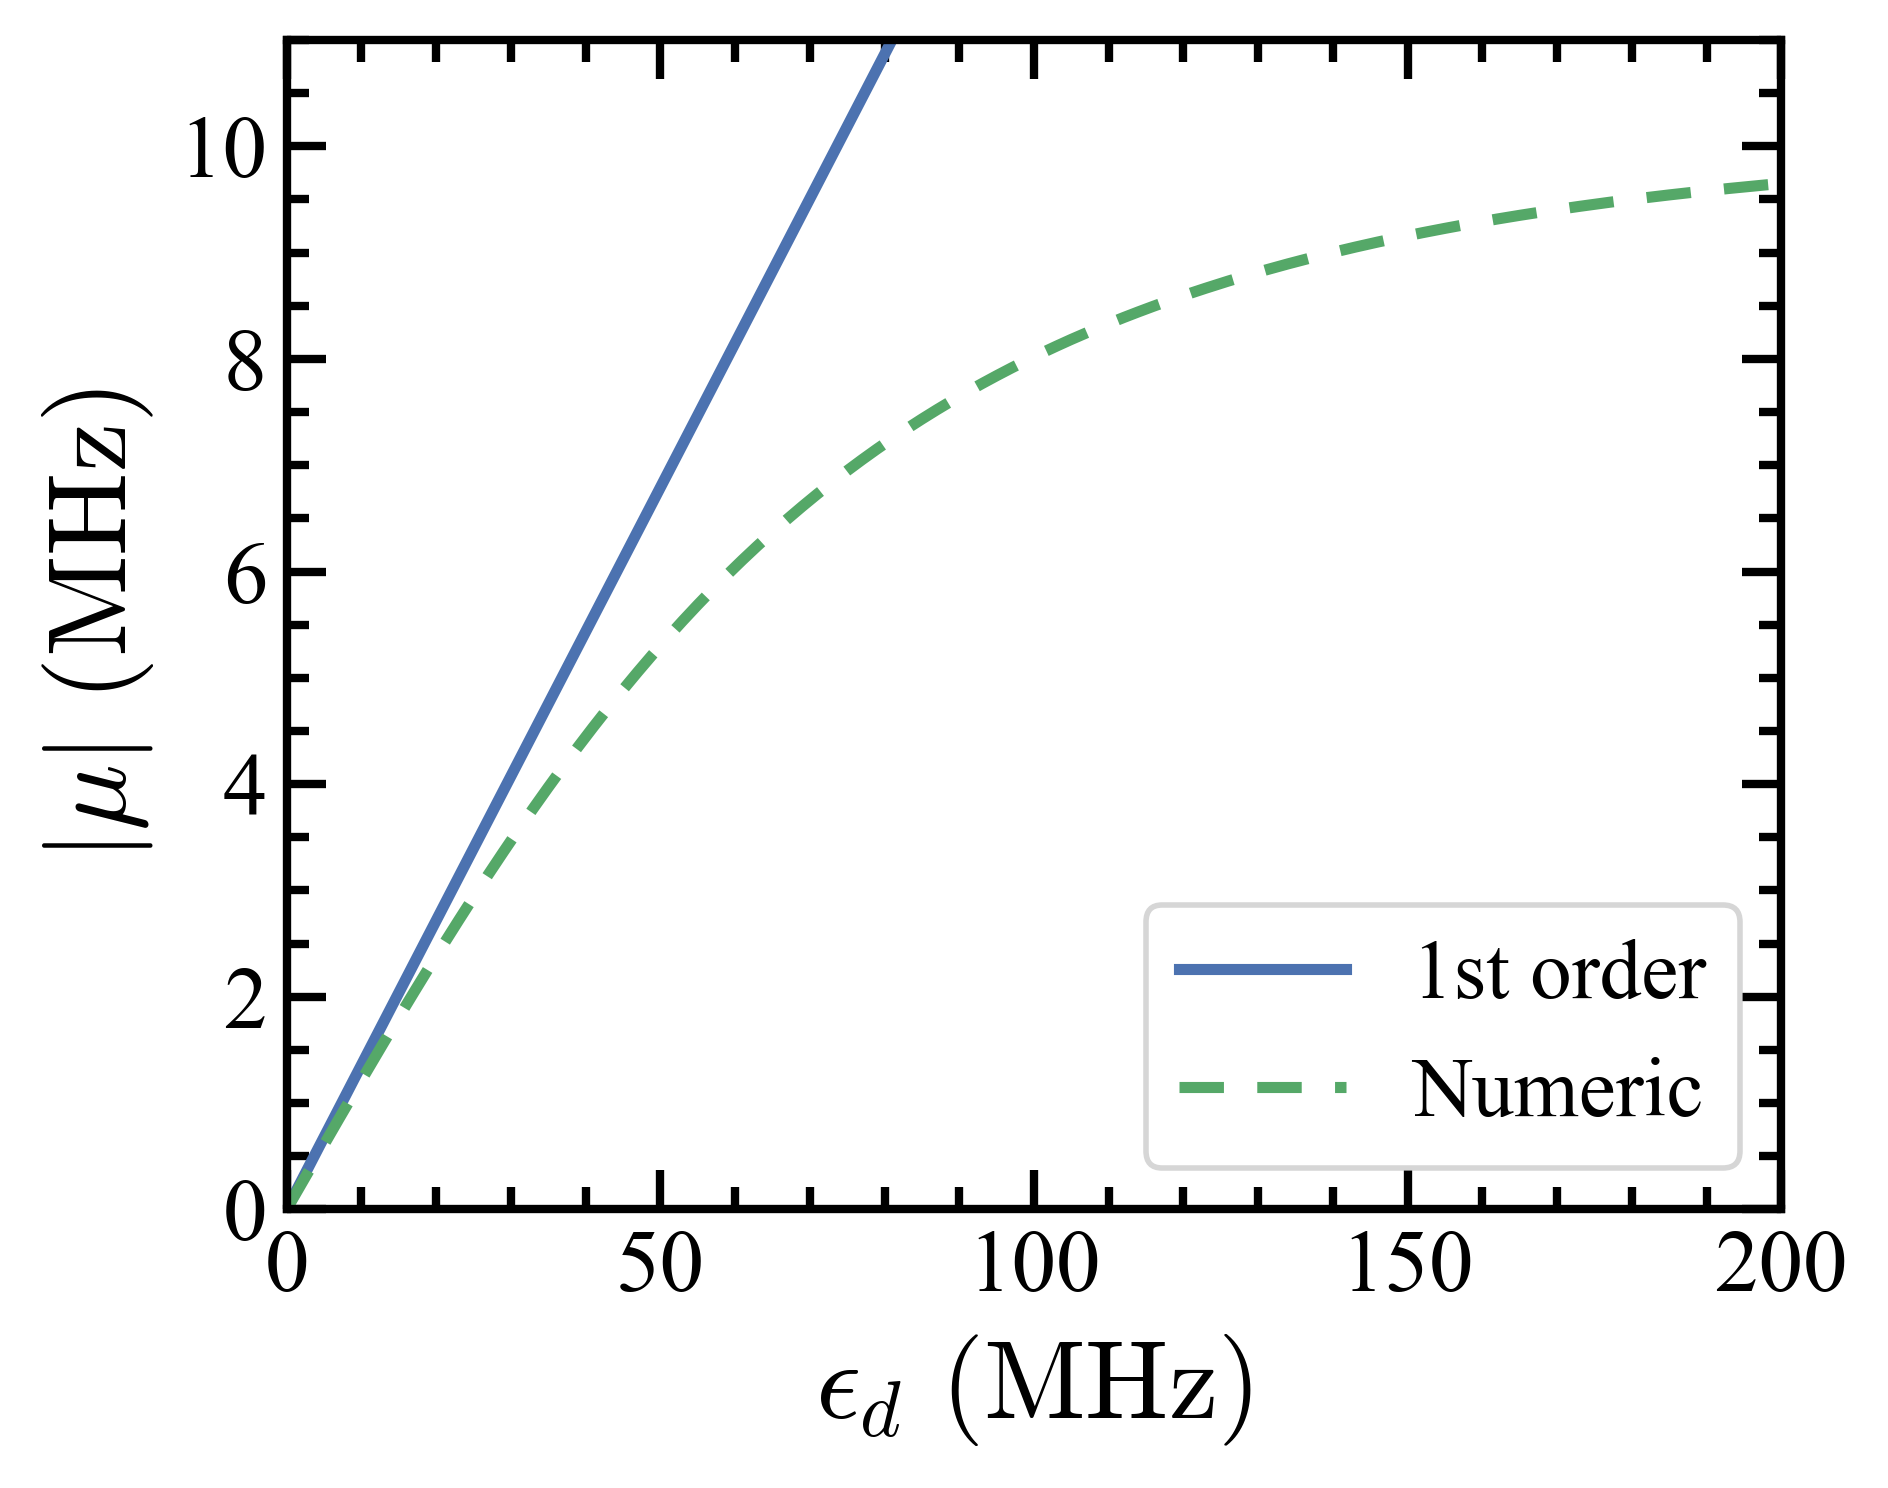

In [13]:
gate_rate = np.load(figpath+'/CR_amp_vs_rate_TLS.npy')
plt.figure(figsize = [5,4])
w1 = 0.5
w2 = 0.581
coupl_array = np.linspace(5,200,196)
coupl_array = np.insert(coupl_array,0,0) 
detuning = w2 - w1
plt.plot(coupl_array, coupl_array*J/detuning, label = '1st order')
plt.plot(coupl_array,gate_rate*1e3,'--', label = 'Numeric')   
plt.xlabel(r'$\epsilon_d~(\mathrm{MHz})$')
plt.ylabel(r'$|\mu|~(\mathrm{MHz})$')
plt.ylim([0,11])
plt.xlim([0,200])
plt.tight_layout()
plt.legend()
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figname = 'CR_gate1.pdf'
plt.savefig(figpath+figname)

## Sweep detuning, find gate rate

In [18]:
#Qubit frequency
w1 = 0.23
J = 0.011 #GHz

#Gate parameters
T_start = 0
T_gate = 2000
shape = 'square'
drag = False
drag_coeff = 0

coupl = 200
coupl_const = coupl*1e-3*2*np.pi
H1 = coupl_const*(XI) #Driving first qubit only
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
detune_array = np.linspace(0.02,1,197)
sz_detune = np.zeros((len(t_points), len(detune_array)))

for idx, detune in enumerate(detune_array):
    w2 = w1 + detune
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    drive_freq = eig_energies[2]-eig_energies[0]
    state_00 = eig_states[0]
    state_01 = eig_states[2]
    state_10 = eig_states[1]
    state_11 = eig_states[3]
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points = t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, omega_d=drive_freq)
    sz_detune[:,idx] = (expect(IZ,U_t*state_00))
#     print (idx)

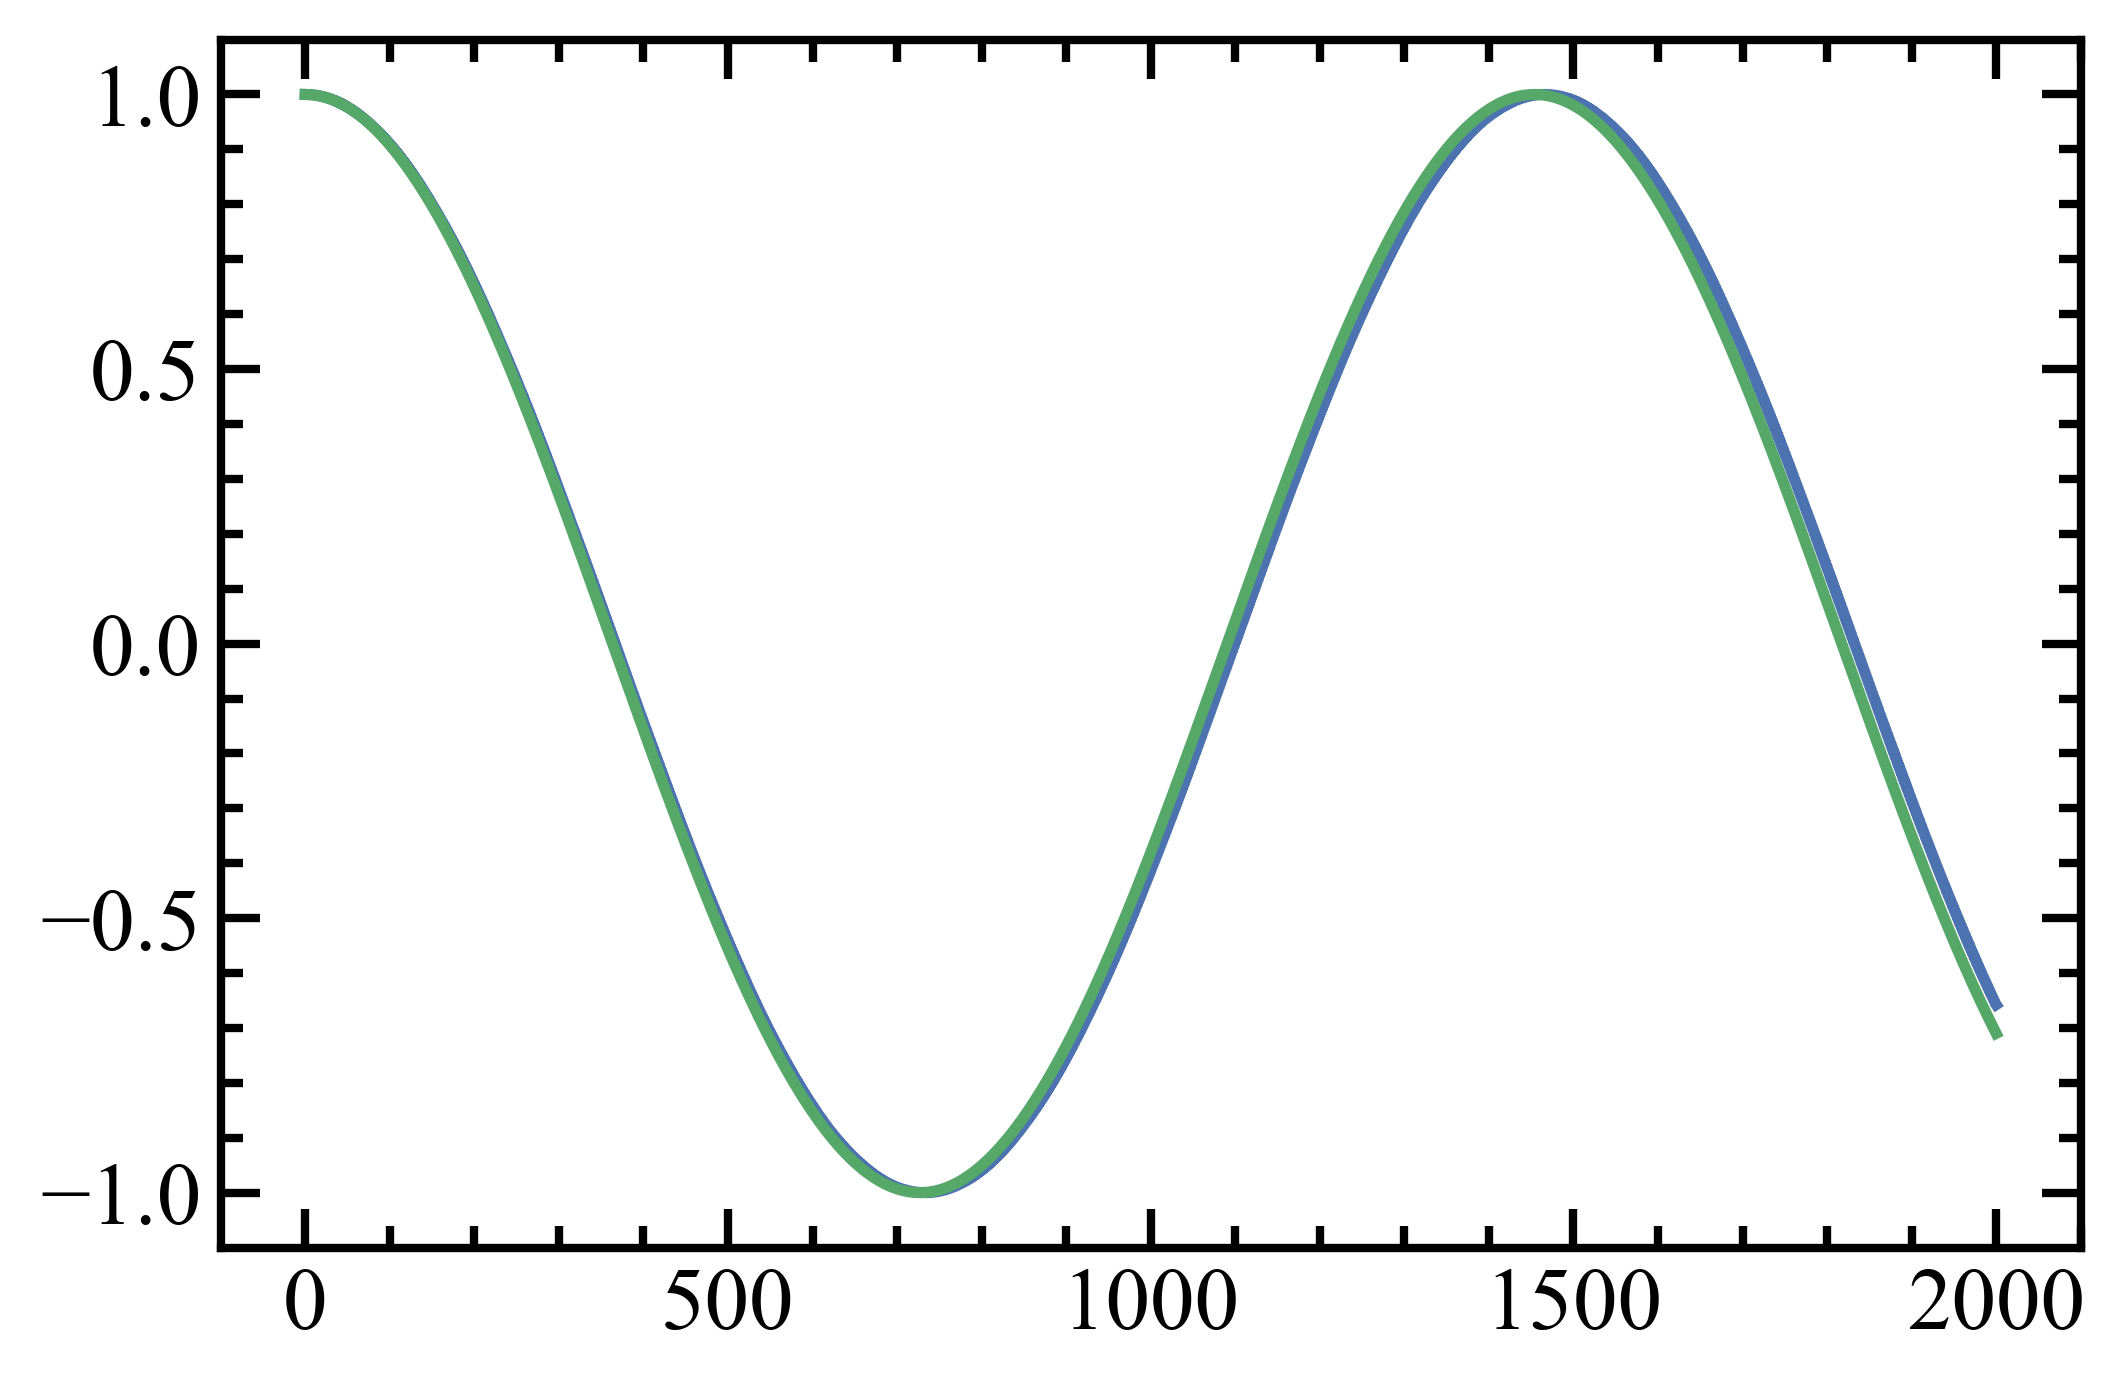

In [21]:
def cosine_func(x,amp,freq,c1,c2):
    return amp*np.cos(2*np.pi*freq*(x-c1))+c2

# detune_array = np.linspace(0.02,1,201)
gate_rate = np.zeros_like(detune_array)

guess =[1,0.0005,0,0]
opt,cov = curve_fit(cosine_func, xdata = t_points, ydata = sz_detune[:,-2], p0=guess, maxfev = 10000)
plt.plot(t_points,sz_detune[:,-1])
plt.plot(t_points,cosine_func(t_points, *opt))

length = len(detune_array)
for idx in range(length):
    if idx == 0:
        freq_guess = 0.0005
    else:
        freq_guess = gate_rate[-idx]
    
    guess =[1,freq_guess,0,0]
    opt,cov = curve_fit(cosine_func, xdata = t_points, ydata = sz_detune[:,-idx-1], p0=guess, maxfev = 1000000)
    gate_rate[-idx-1] = opt[1]
np.save(figpath+'/CR_detune_vs_rate_TLS.npy',gate_rate)

In [32]:
detune_array[2]*1e3

30.0

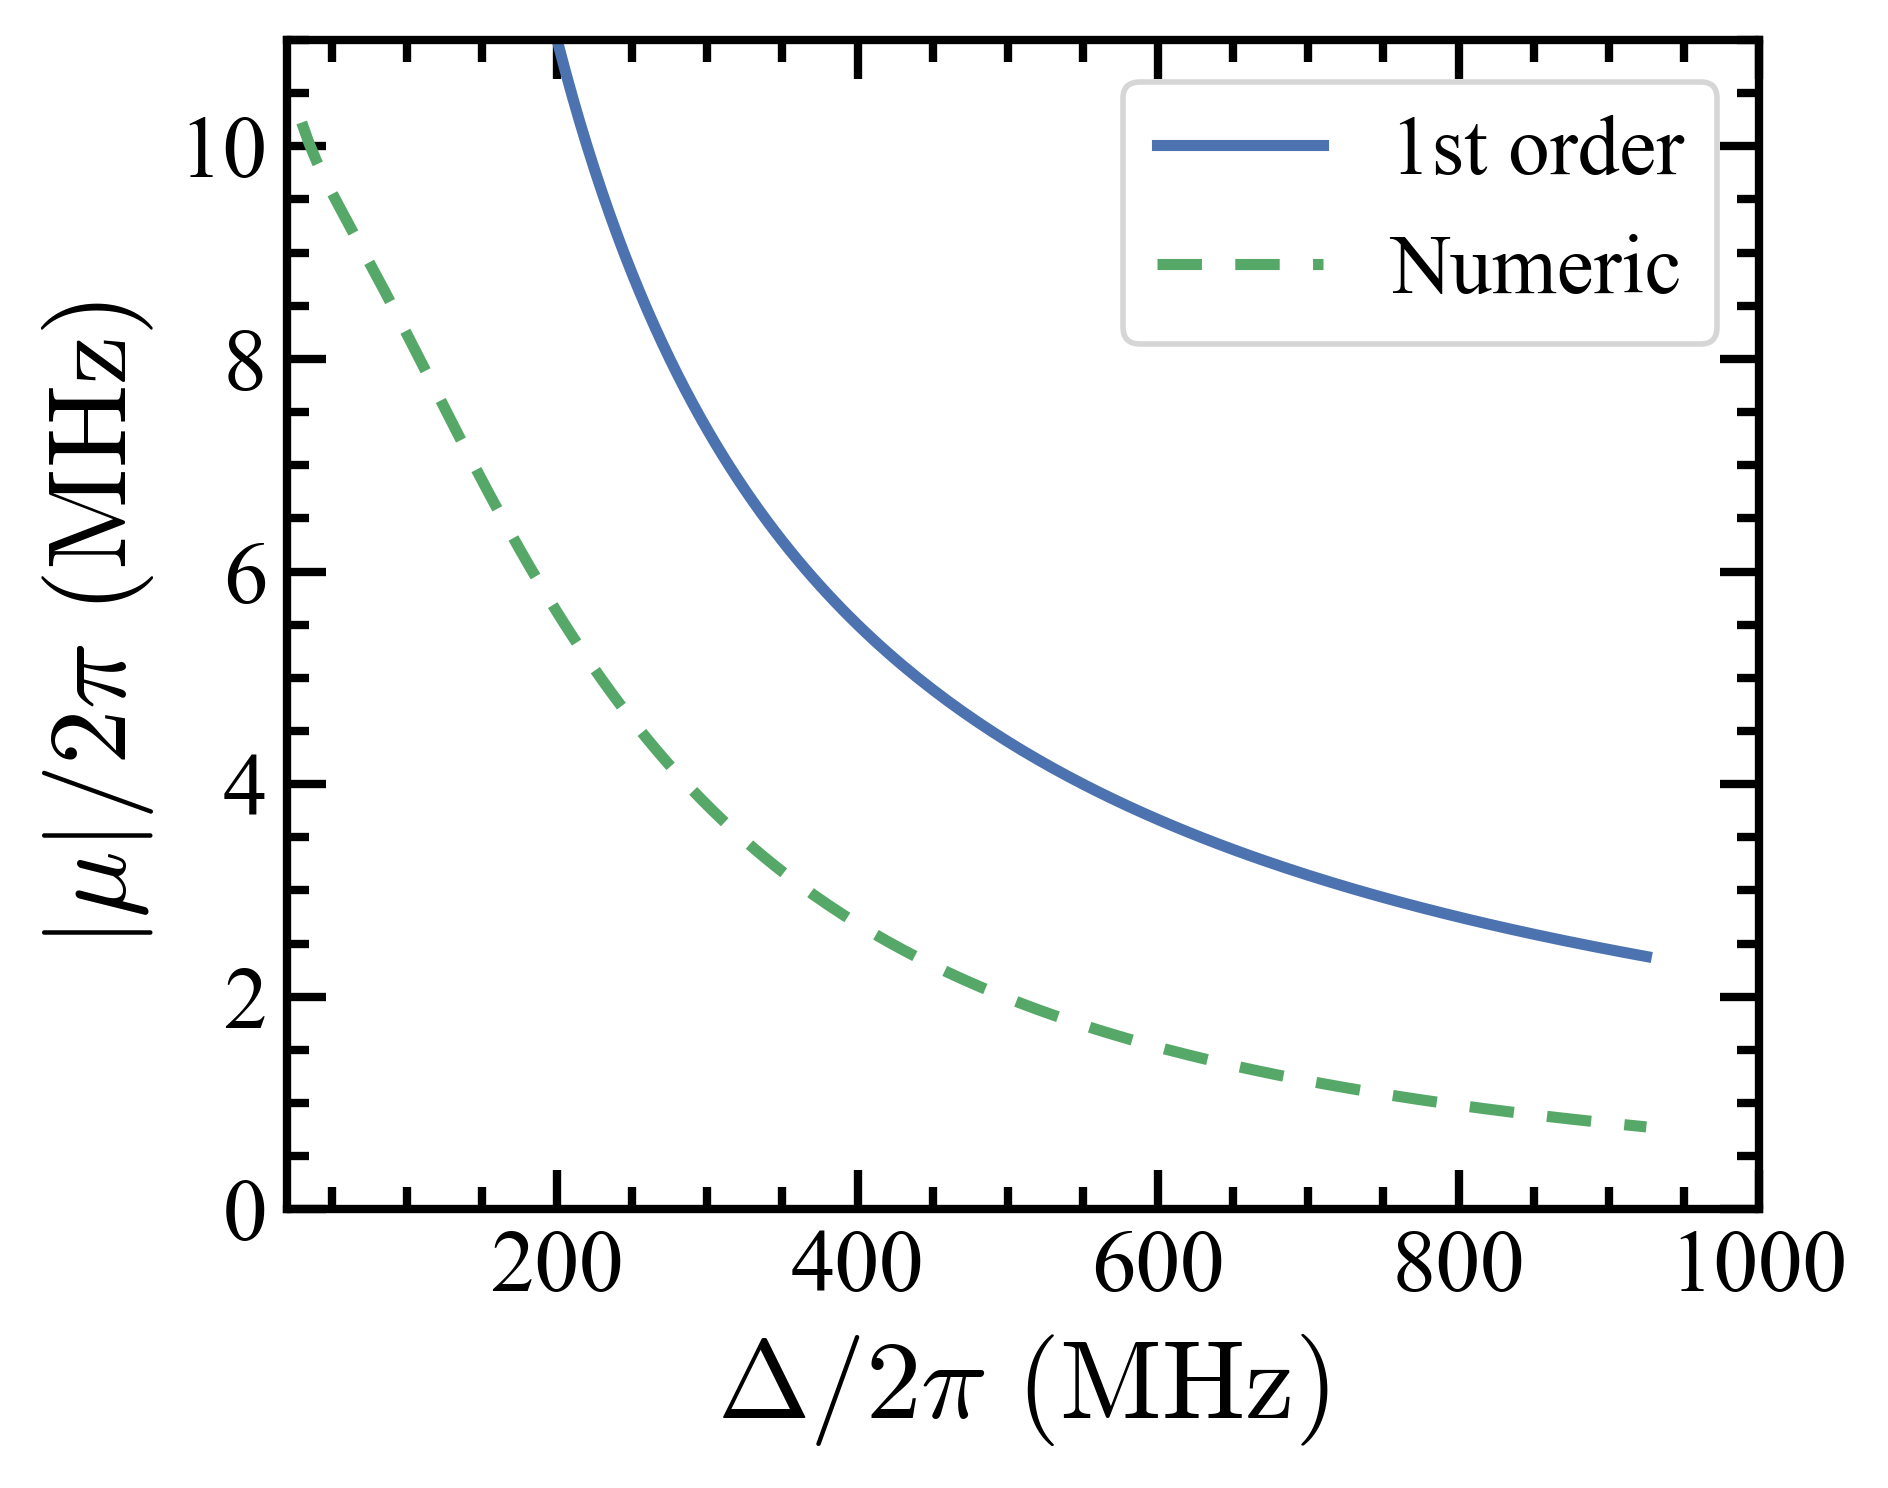

In [33]:
gate_rate = np.load(figpath+'/CR_detune_vs_rate_TLS.npy')
detune_array = np.linspace(0.02,1,197)
plt.figure(figsize = [5,4])
plt.plot(detune_array[2:-15]*1e3, coupl*J/(detune_array[2:-15]), label = '1st order')
plt.plot(detune_array[2:-15]*1e3, gate_rate[2:-15]*1e3,'--', label = 'Numeric')   
plt.xlabel(r'$\Delta/2\pi~(\mathrm{MHz})$')
plt.ylabel(r'$|\mu|/2\pi~(\mathrm{MHz})$')
plt.ylim([0,11])
# plt.xlim([detune_array[0]*1e3,detune_array[-1]*1e3])
plt.xlim(20,1000)
plt.tight_layout()
plt.legend()
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figname = 'CR_gate2.pdf'
plt.savefig(figpath+figname)

## Sweep rise time, find optimal drive amplitude

In [101]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

J = 0.011 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates()

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]

#Gate parameters
drive_freq = eig_energies[2]-eig_energies[0]
shape = 'cosflattop'
drag = False
T_start = 0


T_gate_array = np.linspace(100,300,101)
T_rise_array = np.linspace(25,50,6)
amp_opt = np.zeros((len(T_rise_array), len(T_gate_array)))
infidel = np.zeros((len(T_rise_array), len(T_gate_array)))
U_ideal = cnot()

for idx, T_rise in enumerate(T_rise_array):
    for idy, T_gate in enumerate(T_gate_array):
        t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
        
        def infidelity(x):
            coupl = x[0]
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)

            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2

            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        coupl_guess = 10*100/T_gate
        x0 = [coupl_guess] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        infidel[idx,idy] = infidelity(xopt.x)
        amp_opt[idx,idy] = xopt.x[0]
np.save(figpath+'/CR_amp_vs_tau_TLS.npy',amp_opt)

In [102]:
# for idx in range (5):
#     plt.plot(T_gate_array, infidel[idx,:])
# plt.yscale("log")


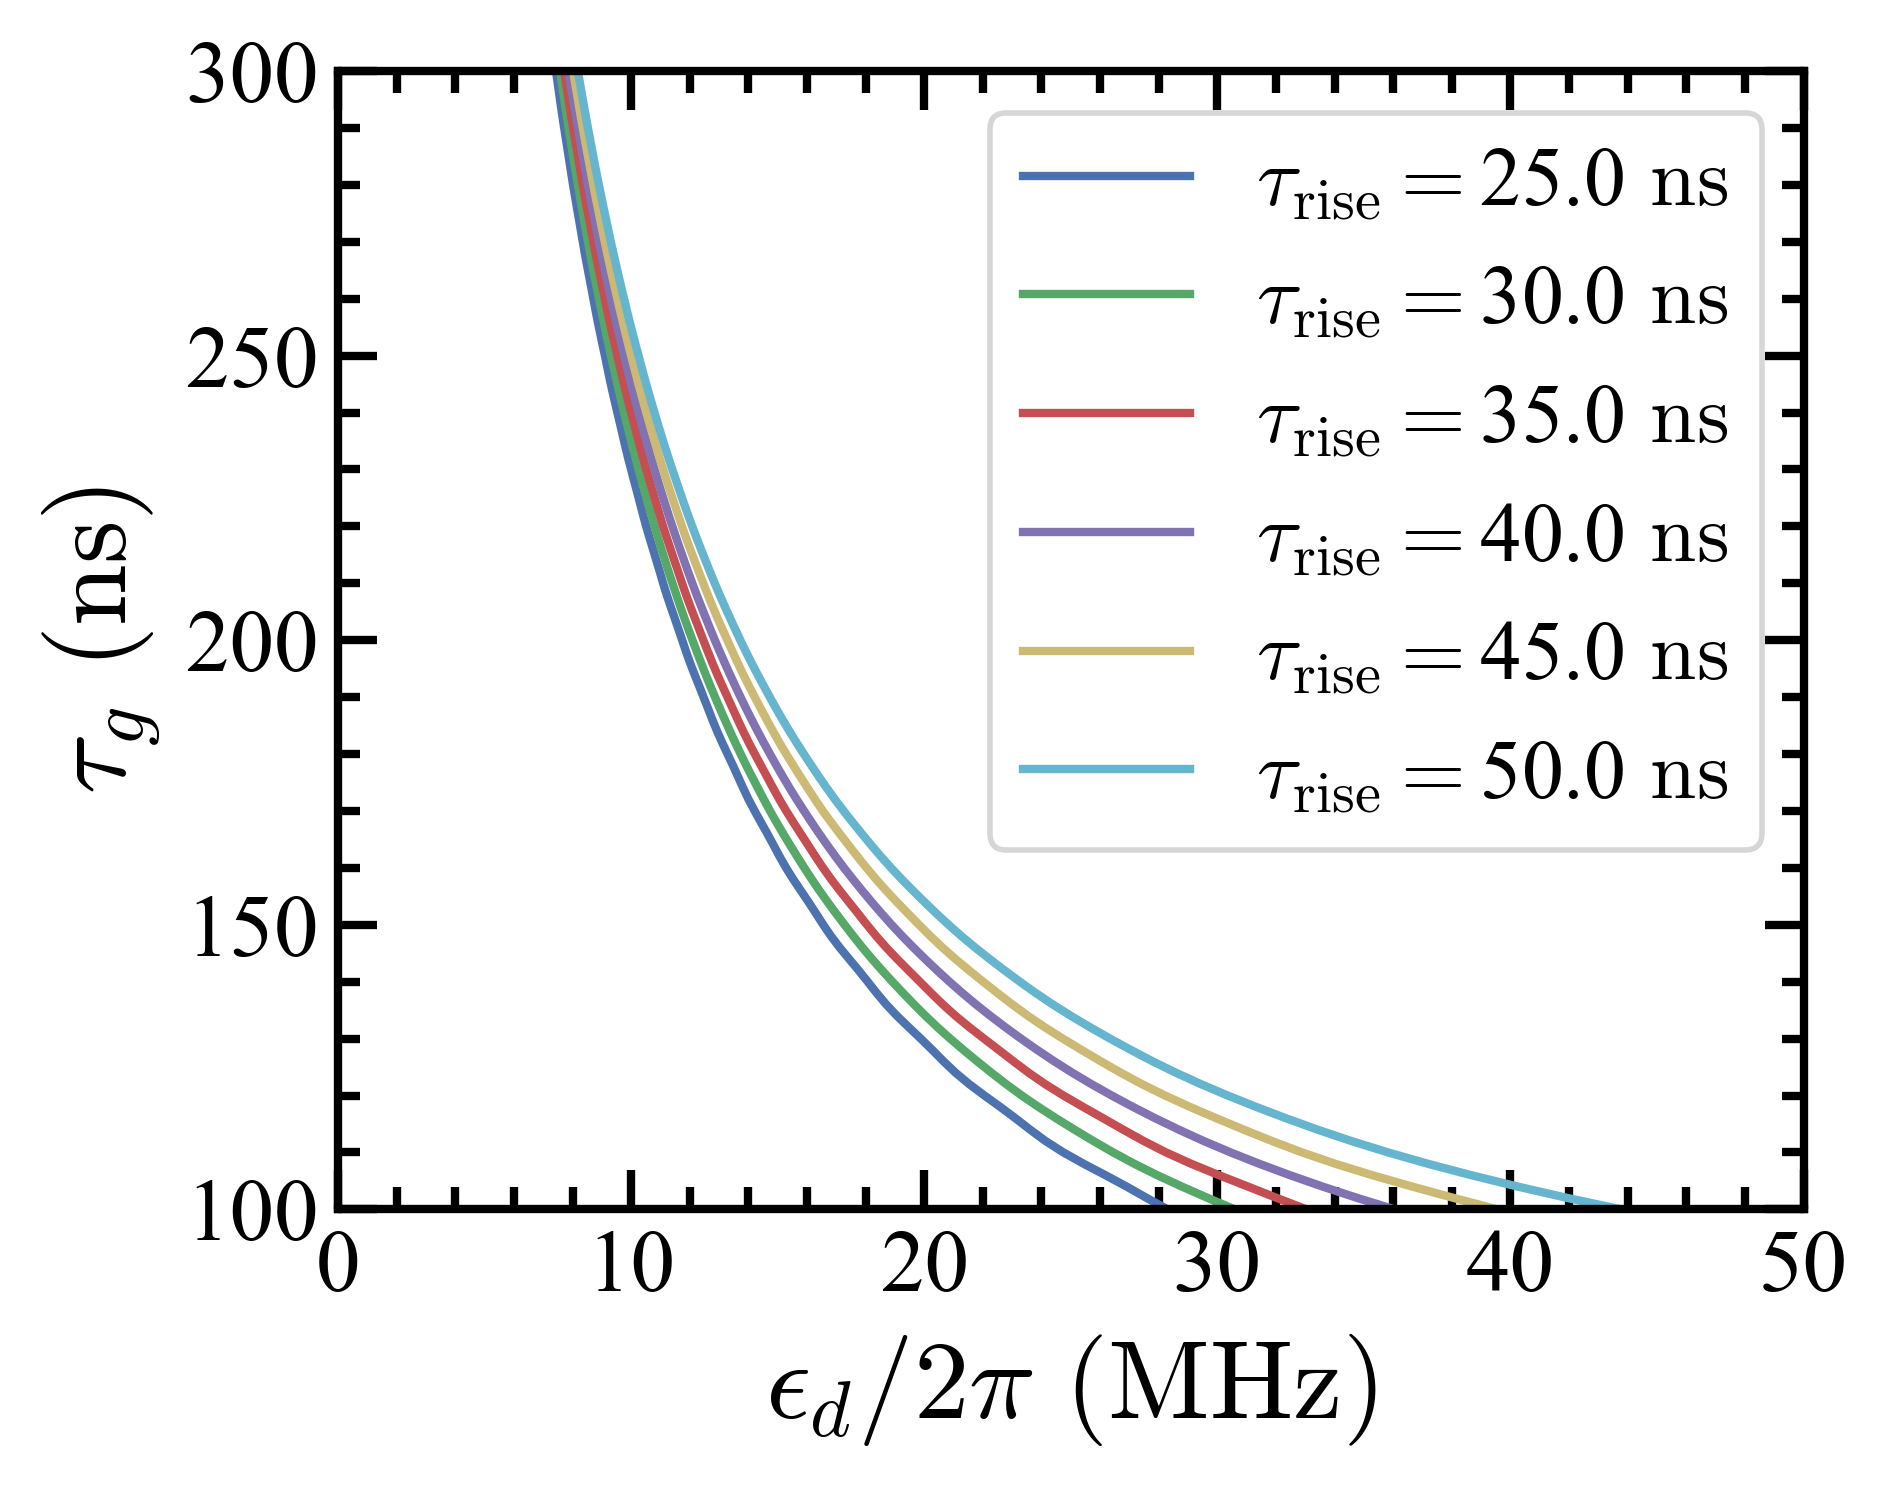

In [107]:
T_gate_array = np.linspace(100,300,101)
T_rise_array = np.linspace(25,50,6)
plt.figure(figsize=[5,4])
for idx in range (6):
    txtstring = r'$\tau_\mathrm{rise} =$' + str(T_rise_array[idx])+r'$~\mathrm{ns}$'
    plt.plot(amp_opt[idx,:], T_gate_array, linewidth = 1.5, label = txtstring)
plt.xlim([0,50])
plt.ylim([100,300])
plt.ylabel(r'$\tau_g~(\mathrm{ns})$')
plt.xlabel(r'$\epsilon_d/2\pi~(\mathrm{MHz})$')
# plt.text(amp_opt[-1,0]-30,T_gate_array[0]+15,r'$\tau_\mathrm{rise} = 50~\mathrm{ns}$')
# plt.text(amp_opt[0,0]-38,T_gate_array[0]+15,r'$\tau_\mathrm{rise} = 25~\mathrm{ns}$')
plt.legend()
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.tight_layout()
figname = 'CR_gate3.pdf'
plt.savefig(figpath+figname)

## Sweep coupling strength, find optimal drive amplitude

In [109]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

#Gate parameters
shape = 'cosflattop'
drag = False
T_start = 0
T_gate_array = np.linspace(100,300,101)
T_rise_array = 50

J_array = np.linspace(2,10,5)*1e-3
amp_opt = np.zeros((len(J_array), len(T_gate_array)))
infidel = np.zeros((len(J_array), len(T_gate_array)))
U_ideal = cnot()

for idx, J in enumerate(J_array):
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    state_00 = eig_states[0]
    state_01 = eig_states[2]
    state_10 = eig_states[1]
    state_11 = eig_states[3]
    drive_freq = eig_energies[2]-eig_energies[0]
    for idy, T_gate in enumerate(T_gate_array):
        t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
        def infidelity(x):
            coupl = x[0]
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)

            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2

            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        if idy == 0:
            coupl_guess = 200
        else:
            coupl_guess = amp_opt[idx,idy-1]
        x0 = [coupl_guess] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        infidel[idx,idy] = infidelity(xopt.x)
        amp_opt[idx,idy] = xopt.x[0]

In [110]:
np.save(figpath+'/CR_coupling_vs_gatetime_TLS.npy',amp_opt)

In [114]:
#Qubit frequency
w1 = 0.5
w2 = 0.581

#Gate parameters
shape = 'cosflattop'
drag = False
T_start = 0
T_gate_array = np.linspace(150,300,76)
T_rise_array = 50

J_array = np.linspace(2,2,1)*1e-3
amp_opt = np.zeros((len(J_array), len(T_gate_array)))
infidel = np.zeros((len(J_array), len(T_gate_array)))
U_ideal = cnot()

for idx, J in enumerate(J_array):
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    state_00 = eig_states[0]
    state_01 = eig_states[2]
    state_10 = eig_states[1]
    state_11 = eig_states[3]
    drive_freq = eig_energies[2]-eig_energies[0]
    for idy, T_gate in enumerate(T_gate_array):
        t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
        def infidelity(x):
            coupl = x[0]
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)

            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2

            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        if idy == 0:
            coupl_guess = 200
        else:
            coupl_guess = amp_opt[idx,idy-1]
        x0 = [coupl_guess] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        infidel[idx,idy] = infidelity(xopt.x)
        amp_opt[idx,idy] = xopt.x[0]
np.save(figpath+'/CR_coupling_vs_gatetime_TLS_1.npy',amp_opt)

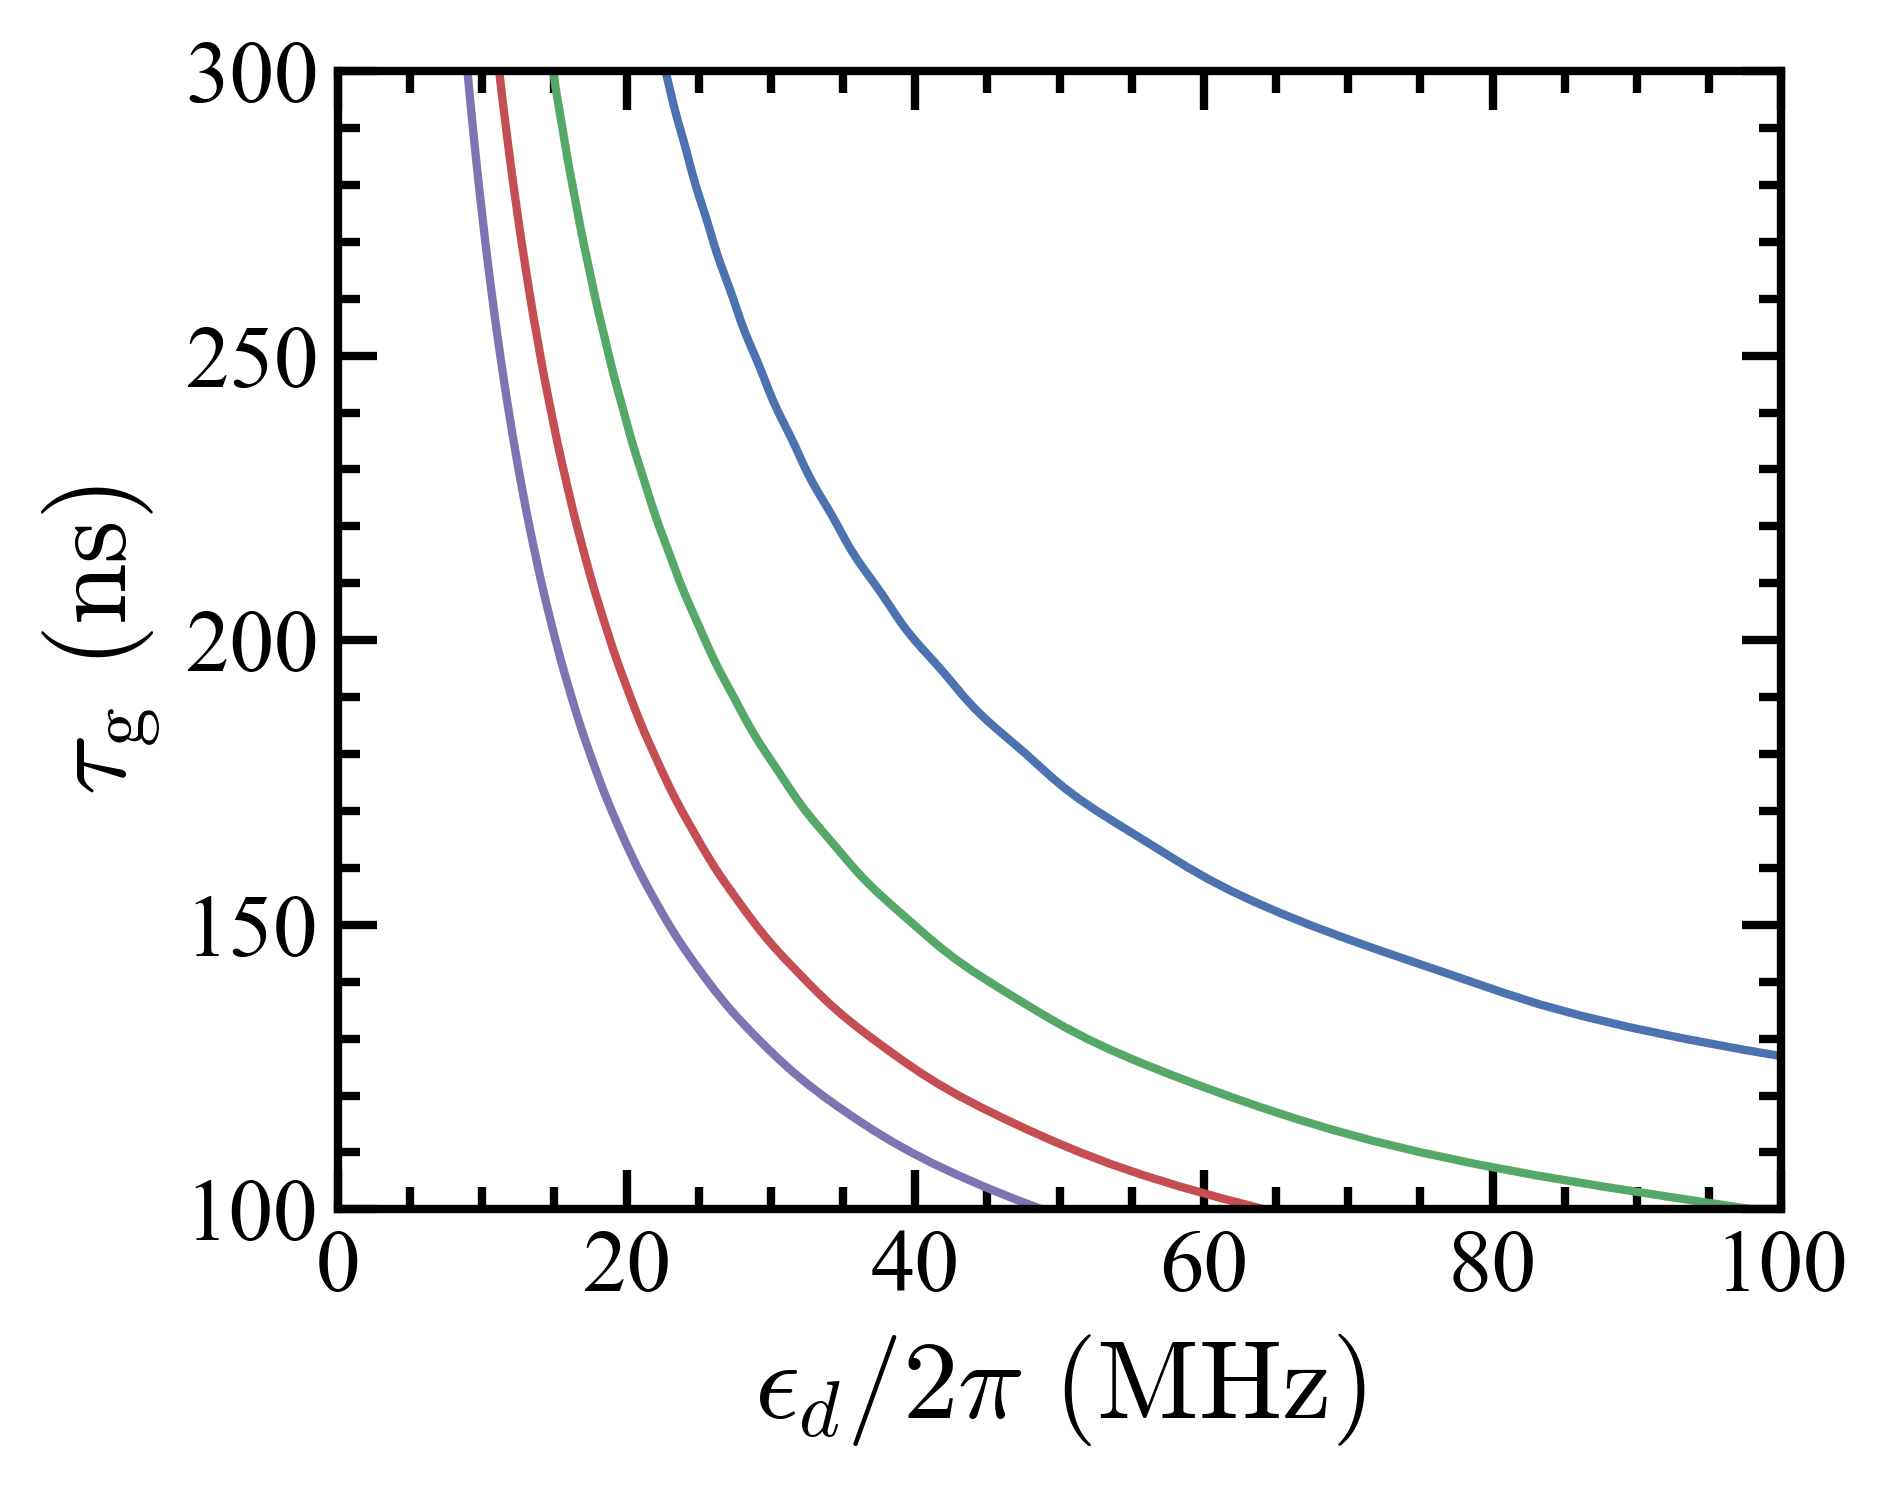

In [125]:
plt.figure(figsize=[5,4])
# amp_opt = np.load(figpath+'/CR_coupling_vs_gatetime_TLS_1.npy')
# T_gate_array = np.linspace(150,300,76)
# txtstring = r'$J_\mathrm{eff} =$' + str(2)+r'$~\mathrm{MHz}$'
# plt.plot(amp_opt[0,:][::-1], T_gate_array[::-1], linewidth = 1.5)
amp_opt = np.load(figpath+'/CR_coupling_vs_gatetime_TLS.npy')
J_array = np.linspace(2,10,5)*1e-3
T_gate_array = np.linspace(100,300,101)
for idx in range (1,len(J_array)):
    plt.plot(amp_opt[idx,:], T_gate_array, linewidth = 1.5)


plt.xlim([0,100])
plt.ylim([100,300])
plt.ylabel(r'$\tau_g~ (\mathrm{ns})$')
plt.xlabel(r'$\epsilon_d/2\pi~ (\mathrm{MHz})$')
plt.tight_layout()
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figname = 'CR_gate5.pdf'
plt.savefig(figpath+figname)

In [ ]:
# 1

## Sweep detuning, find fidelity, vary gate time

In [184]:
#Gate parameters to sweep
detuning_array = np.linspace(50,1000,385)*1e-3

#Qubit frequency
w1 = 0.23
J = 0.009 #GHz
shape = 'cosflattop'
infidelity_array = np.zeros((len(detuning_array)))
coupl_const_array = np.zeros((len(detuning_array)))
T_start = 0
T_gate = 200
t_points = np.linspace(0, T_gate, 2*int(T_gate)+1)
T_rise = T_gate/3.0

for d_idx, detuning in enumerate (detuning_array):
    w2 = w1 + detuning
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    drive_freq = eig_energies[2] - eig_energies[0]
    U_ideal = (eig_states[0]*eig_states[0].dag() + eig_states[2]*eig_states[2].dag() + eig_states[1]*eig_states[1].dag() + eig_states[3]*eig_states[3].dag()) \
    + 1.0j*(eig_states[0]*eig_states[2].dag() + eig_states[2]*eig_states[0].dag()) \
    - 1.0j*(eig_states[1]*eig_states[3].dag() + eig_states[3]*eig_states[1].dag())
    U_ideal = U_ideal/np.sqrt(2)
    
    def infidelity(x):
        coupl = x[0]
        coupl_const = coupl*1e-3*2*np.pi
        H1 = coupl_const*(XI)
        U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, T_start = T_start,
            T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)

        phase0 = np.angle(U_t[-1].matrix_element(eig_states[0].dag(), eig_states[0]))
        phase1 = np.angle(U_t[-1].matrix_element(eig_states[1].dag(), eig_states[1]))
        phase2 = np.angle(U_t[-1].matrix_element(eig_states[2].dag(), eig_states[2]))
        phase3 = np.angle(U_t[-1].matrix_element(eig_states[3].dag(), eig_states[3]))

        single_qu_z = 0
        single_qu_z = single_qu_z + np.exp(-1j*phase0)*eig_states[0]*eig_states[0].dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*eig_states[1]*eig_states[1].dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*eig_states[2]*eig_states[2].dag()
#         single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*eig_states[3]*eig_states[3].dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase3)*eig_states[3]*eig_states[3].dag()
        U = single_qu_z*U_t[-1]

        U_real = U
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
        return abs(1.0-fidel)
    
    if d_idx == 0:
        coupl_guess = 13
    else:
        coupl_guess = coupl_const_array[d_idx-1]
    x0 = [coupl_guess] #guess
    xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = 1e-8)
    coupl_const_array[d_idx] = xopt.x[0]
    infidelity_array [d_idx] = infidelity(xopt.x)
    print (d_idx)
    print (xopt.x)
    print(infidelity(xopt.x))
    now = datetime.now()
    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("date and time =", dt_string)
np.save(figpath+'/CR_detune_vs_fidelity_1GHz_200ns_TLS_interaction.npy',infidelity_array)

0
[44.52804981]
3.21695776225317e-05
date and time = 28/12/2021 00:00:53
1
[46.86504033]
5.967268624917921e-05
date and time = 28/12/2021 00:01:03
2
[13.62407843]
4.709412325665241e-06
date and time = 28/12/2021 00:01:15
3
[14.26227377]
4.166292441931674e-06
date and time = 28/12/2021 00:01:25
4
[-14.90775947]
4.419215415607525e-06
date and time = 28/12/2021 00:01:37
5
[-15.56037487]
2.1219105190706244e-06
date and time = 28/12/2021 00:01:47
6
[16.21989399]
9.428983871462293e-07
date and time = 28/12/2021 00:01:58
7
[-16.88618555]
2.3038114124185327e-06
date and time = 28/12/2021 00:02:10
8
[-17.55930733]
2.467529985450412e-06
date and time = 28/12/2021 00:02:20
9
[-18.23904357]
2.2423446581765205e-06
date and time = 28/12/2021 00:02:31
10
[18.92544287]
2.527593772838621e-06
date and time = 28/12/2021 00:02:43
11
[-19.61840499]
1.5738354089966933e-06
date and time = 28/12/2021 00:02:56
12
[-20.31783136]
7.835070942041611e-07
date and time = 28/12/2021 00:03:05
13
[21.02363633]
1.353343

109
[11037.08705235]
0.1238518243963821
date and time = 28/12/2021 02:12:01
110
[11084.23402348]
0.12482512050699113
date and time = 28/12/2021 02:14:37
111
[11135.68635704]
0.12580735847495972
date and time = 28/12/2021 02:17:14
112
[11184.48654921]
0.1267734779044073
date and time = 28/12/2021 02:19:35
113
[11234.66109519]
0.1277477888488019
date and time = 28/12/2021 02:21:44
114
[11284.01502171]
0.12873920436694042
date and time = 28/12/2021 02:24:28
115
[11333.88274628]
0.12971497619711558
date and time = 28/12/2021 02:27:15
116
[11382.72999006]
0.1306836848583176
date and time = 28/12/2021 02:30:02
117
[11433.02096705]
0.13162092557447913
date and time = 28/12/2021 02:32:46
118
[11482.54847335]
0.13257595465859884
date and time = 28/12/2021 02:35:27
119
[11531.95873635]
0.13352228189627413
date and time = 28/12/2021 02:38:17
120
[11581.52551837]
0.13447475983952695
date and time = 28/12/2021 02:41:06
121
[11631.28988583]
0.13543955202133406
date and time = 28/12/2021 02:43:49
122

0.37480224871051493
date and time = 28/12/2021 08:31:23
217
[31792.47438799]
0.25965519253474567
date and time = 28/12/2021 08:37:42
218
[33179.41720225]
0.37615442826566226
date and time = 28/12/2021 08:44:13
219
[34565.7812498]
0.2658719350458769
date and time = 28/12/2021 08:51:14
220
[35968.53940658]
0.3773571651655476
date and time = 28/12/2021 09:02:32
221
[36076.38575047]
0.3774209494489318
date and time = 28/12/2021 09:09:59


/Users/longnguyen/opt/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

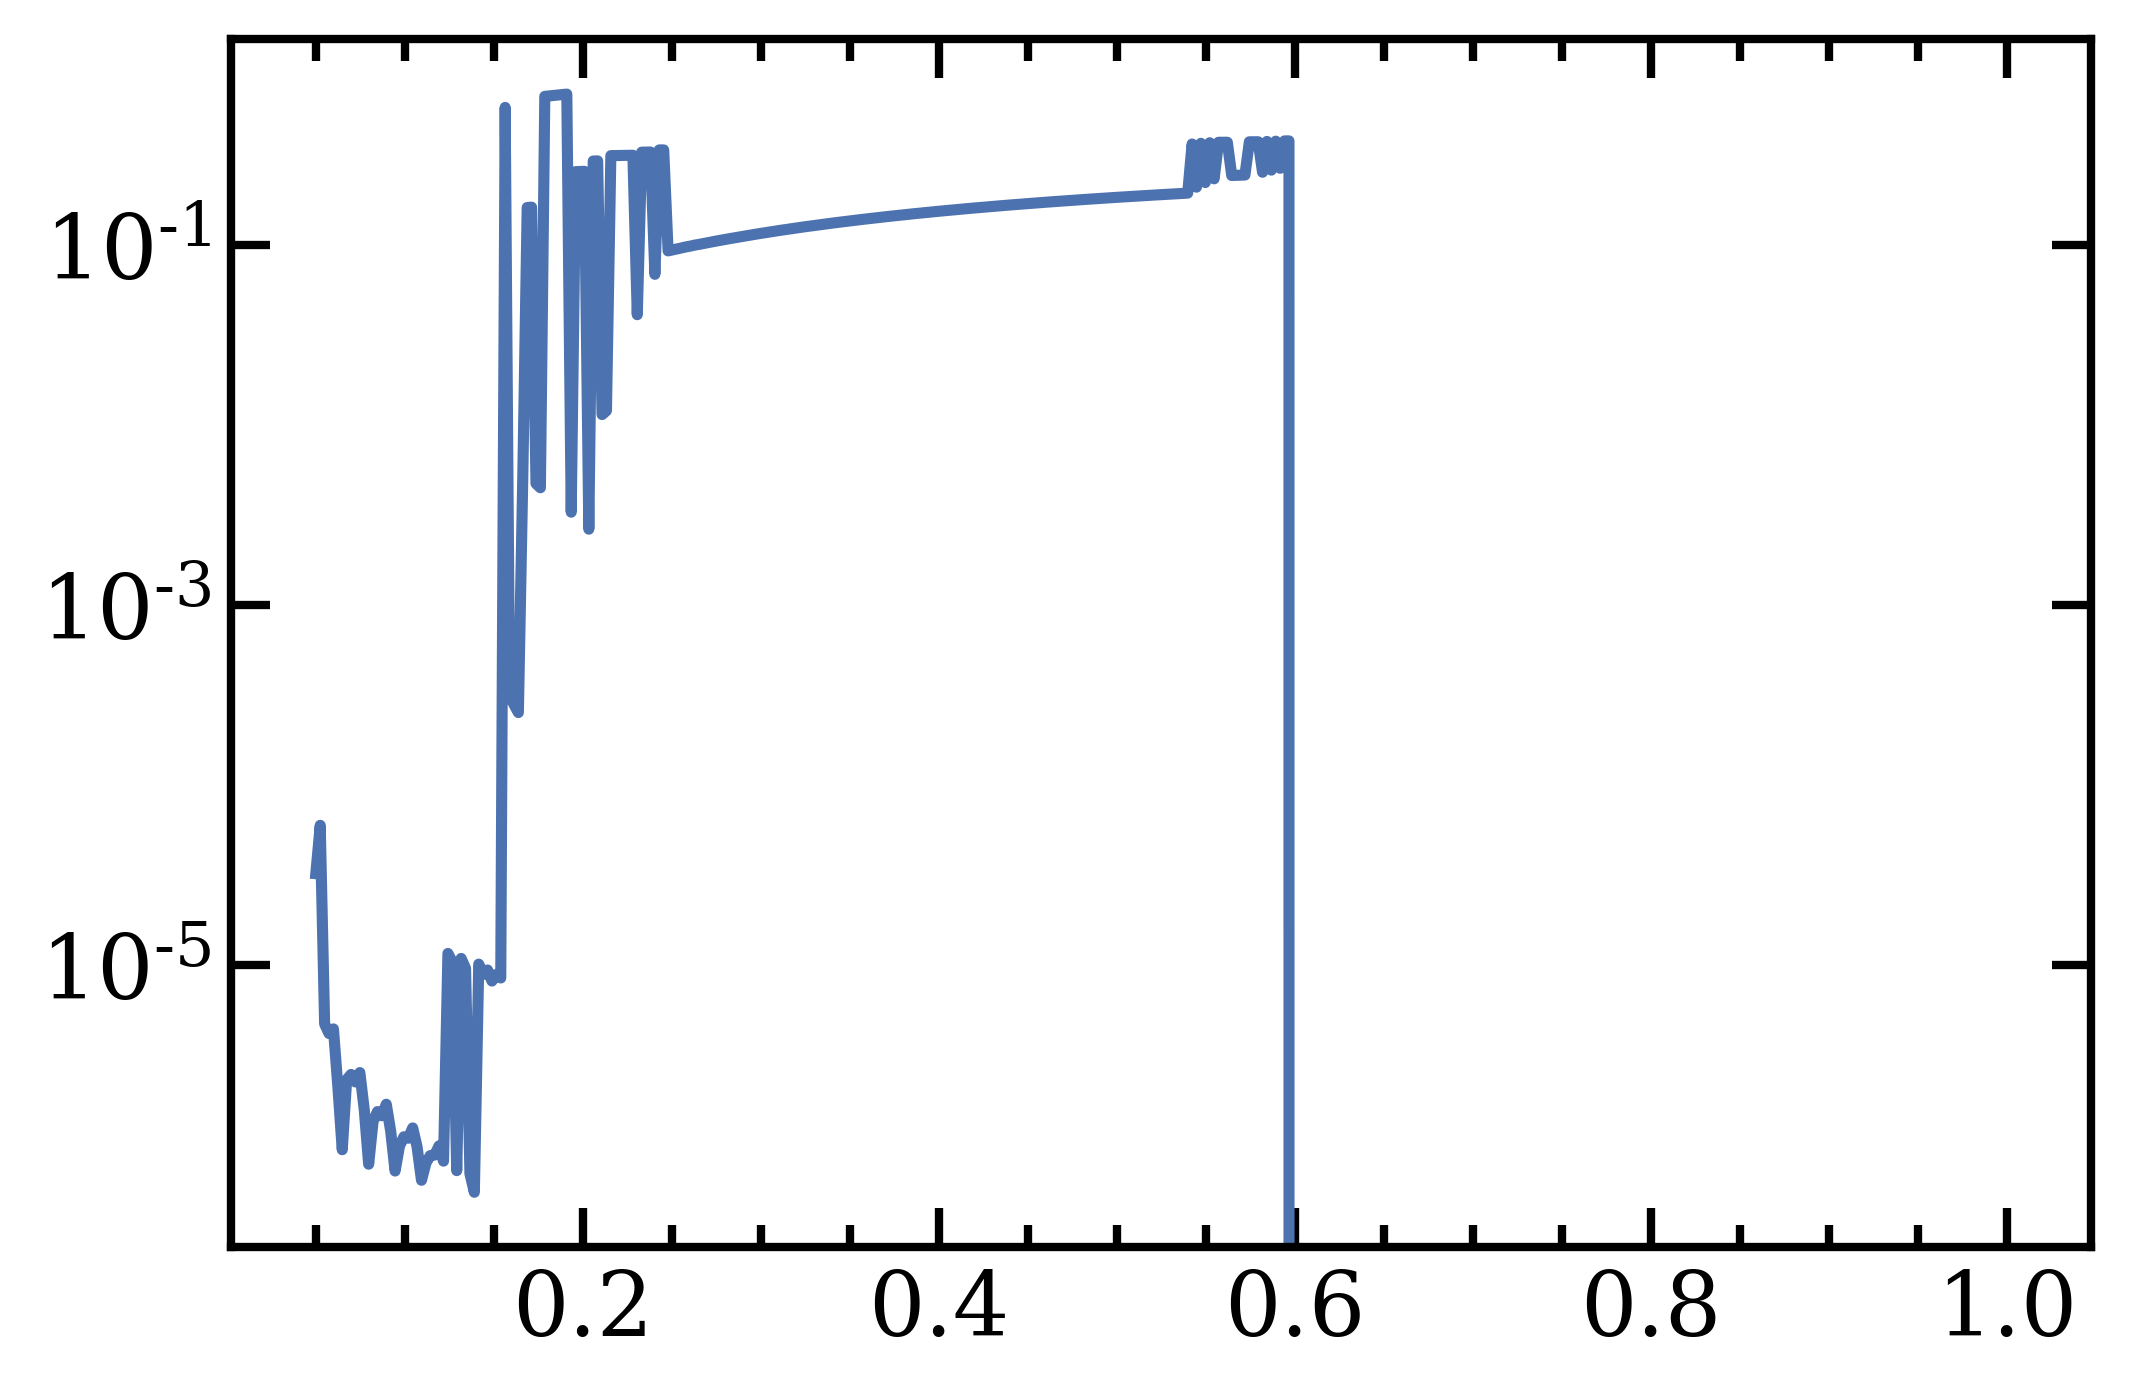

In [185]:
plt.plot(detuning_array, infidelity_array)
plt.yscale('log')

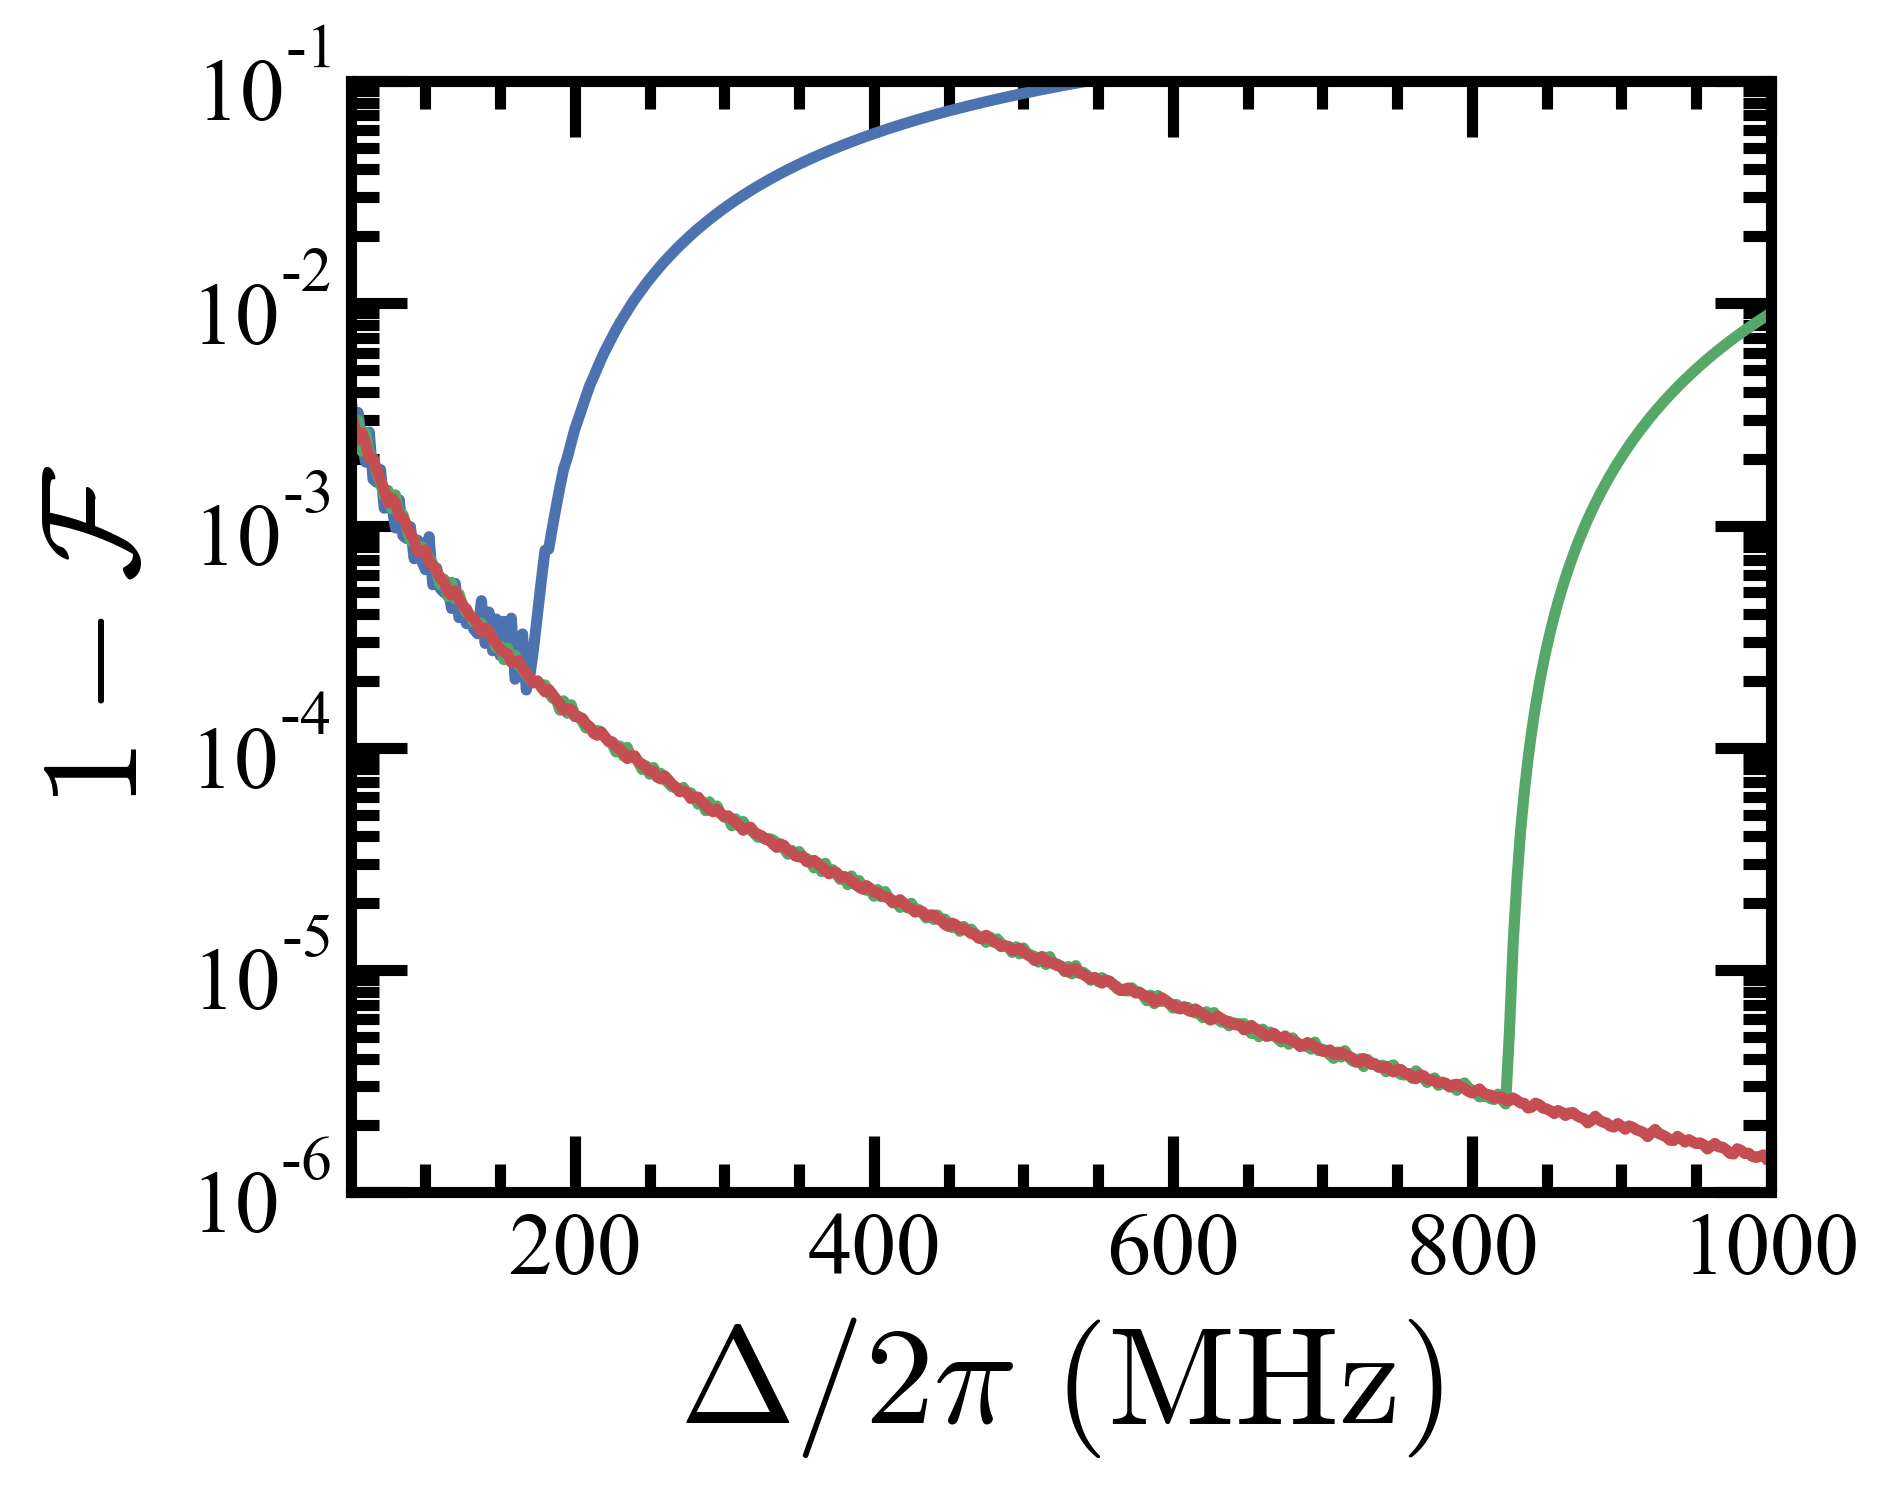

In [31]:
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# detuning_array = np.linspace(50,250,51)*1e-3
# T_gate_array = np.linspace(100,300,3)
# infidelity_array=np.load(figpath+'/CR_detune_vs_fidelity_variedtau_TLS.npy')

detuning_array = np.linspace(50,1000,381)*1e-3
T_gate_array = np.linspace(100,300,3)
infidelity_array=np.load(figpath+'/CR_detune_vs_fidelity_1GHz_variedtau_TLS.npy')

plt.figure(figsize = [5,4])
plt.plot(detuning_array*1e3, infidelity_array[:,0], linewidth = 2, label = r'$\tau_\mathrm{gate}=100~\mathrm{ns}$')
plt.plot(detuning_array*1e3, infidelity_array[:,1], linewidth = 2, label = r'$\tau_\mathrm{gate}=200~\mathrm{ns}$')
plt.plot(detuning_array*1e3, infidelity_array[:,2], linewidth = 2, label = r'$\tau_\mathrm{gate}=300~\mathrm{ns}$')
plt.yscale("log")
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlim([detuning_array[0]*1e3,detuning_array[-1]*1e3])
plt.ylim([1e-6,1e-1])
# plt.legend()
# plt.text(210,2e-4,r'$\tau_\mathrm{gate}=100~\mathrm{ns}$',rotation = 50, fontsize = 11)
# plt.text(115,1e-3,r'$\tau_\mathrm{gate}=100~\mathrm{ns}$',rotation = 70, fontsize = 12)
# plt.text(770,1e-4,r'$\tau_\mathrm{gate}=200~\mathrm{ns}$',rotation = 70, fontsize = 12)
# plt.text(840,2.2e-6,r'$300~\mathrm{ns}$',rotation = -10, fontsize = 12)
plt.tight_layout()
figname = 'CR_extended.pdf'
plt.savefig(figpath+figname)

In [ ]:
U_Z2I = np.exp(1j*np.pi/4)*eig_states[0]*eig_states[0].dag() + np.exp(-1j*np.pi/4)*eig_states[1]*eig_states[1].dag() + np.exp(1j*np.pi/4)*eig_states[2]*eig_states[2].dag() + np.exp(-1j*np.pi/4)*eig_states[3]*eig_states[3].dag()
U_IX2 = np.sqrt(2)**-1*(eig_states[0]*eig_states[0].dag() + eig_states[2]*eig_states[2].dag() + eig_states[1]*eig_states[1].dag() + eig_states[3]*eig_states[3].dag()) \
+ 1.0j*np.sqrt(2)**-1*(eig_states[0]*eig_states[2].dag() + eig_states[2]*eig_states[0].dag() + eig_states[1]*eig_states[3].dag() + eig_states[3]*eig_states[1].dag())

def infidelity(x):
    coupl = x[0]
#     phase_op1 = x[1]
#     phase_op2 = x[2]
    eta = 0
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI+eta*IX)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    phase0 = np.angle(U_t[-1].matrix_element(eig_states[0].dag(), eig_states[0]))
    phase1 = np.angle(U_t[-1].matrix_element(eig_states[1].dag(), eig_states[1]))
    phase2 = np.angle(U_t[-1].matrix_element(eig_states[2].dag(), eig_states[2]))
    phase3 = np.angle(U_t[-1].matrix_element(eig_states[3].dag(), eig_states[3]))

    single_qu_z = 0
    single_qu_z = single_qu_z + np.exp(-1j*phase0)*eig_states[0]*eig_states[0].dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*eig_states[1]*eig_states[1].dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*eig_states[2]*eig_states[2].dag()
    single_qu_z = single_qu_z + np.exp(1.0j*(phase0 - phase1 - phase2))*eig_states[3]*eig_states[3].dag()
    U = single_qu_z*U_t[-1]

#     U_Z2I = tensor(rz(phase_op1), qeye(2))
#     U_IX2 = tensor(qeye(2), rx(phase_op2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return abs(1.0-fidel)

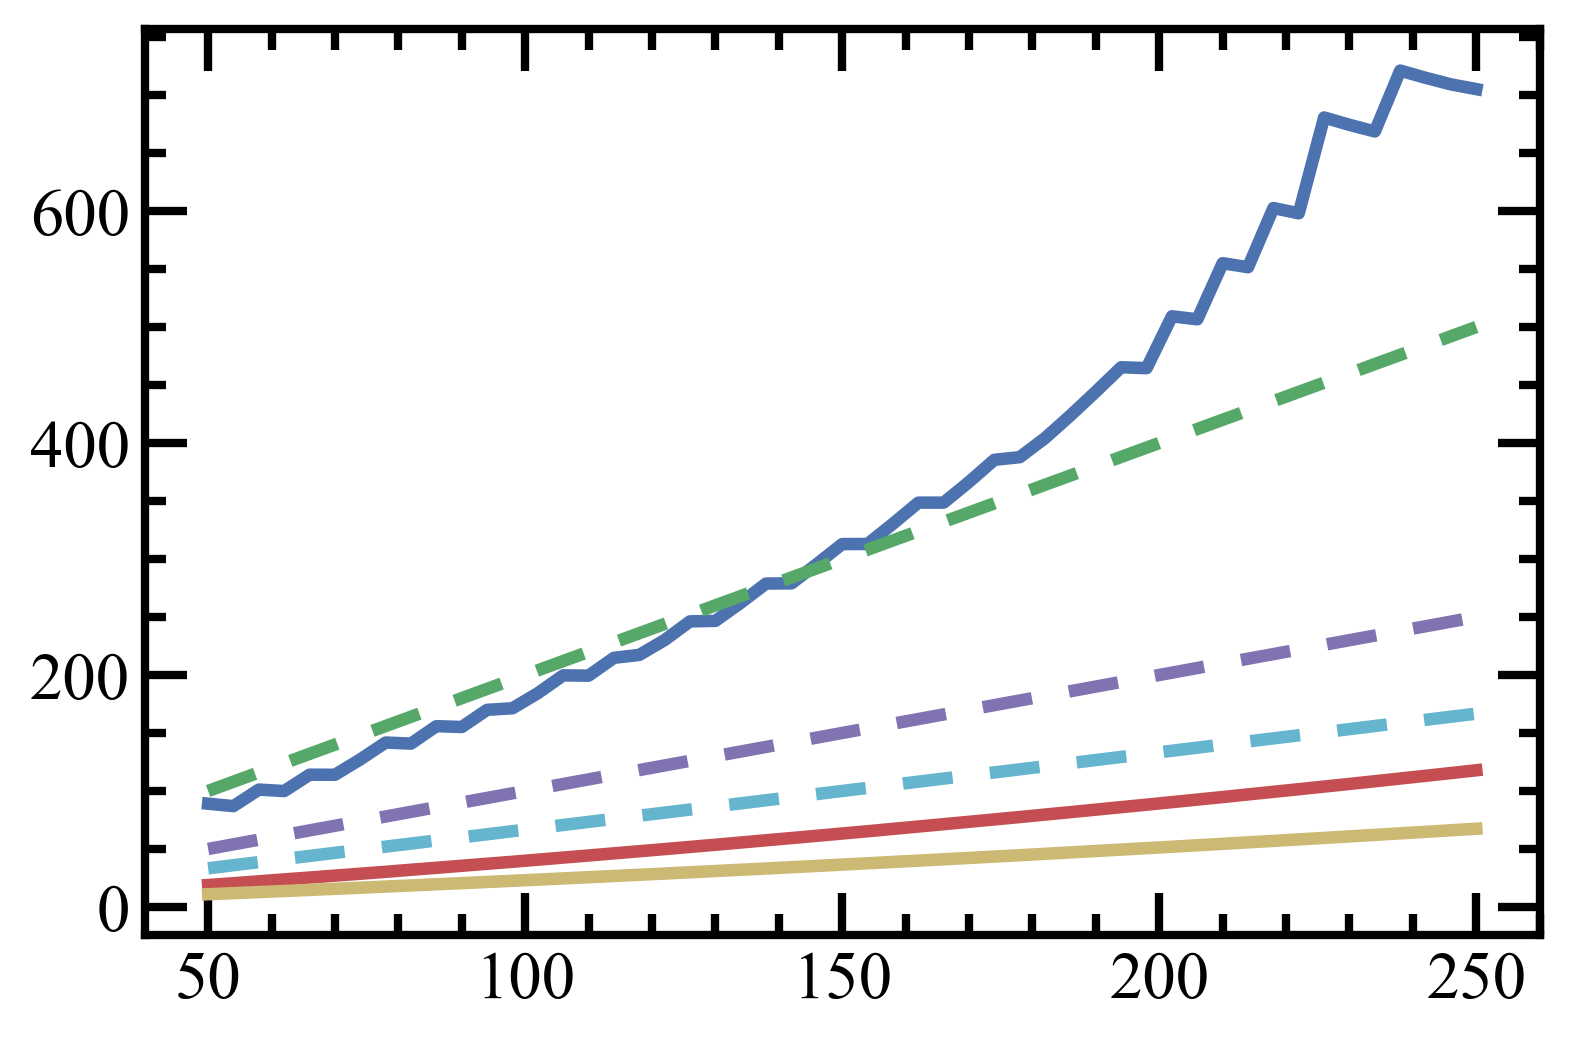

In [498]:
for idx, T_gate in enumerate(T_gate_array):
    plt.plot(detuning_array*1e3, coupl_const_array[:,idx])
    plt.plot(detuning_array*1e3, detuning_array*1e3*2 /(T_gate/100), '--')
# plt.ylim([0,200])

## Sweep detuning, find fidelity, vary qubit-qubit coupling

In [11]:
#Gate parameters to sweep
detuning_array = np.linspace(50,250,51)*1e-3
qcoupling_array = np.linspace(1,10,10)*1e-3

#Qubit frequency
w1 = 0.4
infidelity_array = np.zeros((len(detuning_array),len(qcoupling_array)))
coupl_const_array = np.zeros((len(detuning_array),len(qcoupling_array)))
U_ideal = cnot()
T_start = 0
T_gate = 200
T_rise = 50
t_points = np.linspace(0, T_gate, 2*int(T_gate)+1)
drag = False

for j_idx, J in enumerate(qcoupling_array):
    for d_idx, detuning in enumerate (detuning_array):
        w2 = w1 + detuning
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()

        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[2] - eig_energies[0]
        
        def infidelity(x):
            coupl = x[0]
            drive_freq = eig_energies[2]-eig_energies[0]
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        if d_idx == 0:
            coupl_guess = detuning*1e3*2 /(T_gate/100)
        else:
            coupl_guess = coupl_const_array[d_idx-1,j_idx]
        x0 = [coupl_guess] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None, options ={'xtol': 1e-6,'ftol':1e-7})
        coupl_const_array[d_idx, j_idx] = xopt.x[0]
        infidelity_array [d_idx, j_idx] = infidelity(xopt.x)
        
#Save data here
np.save(figpath+'/CR_detune_vs_fidelity_variedJ_TLS.npy',infidelity_array)

NameError: name 'figpath' is not defined

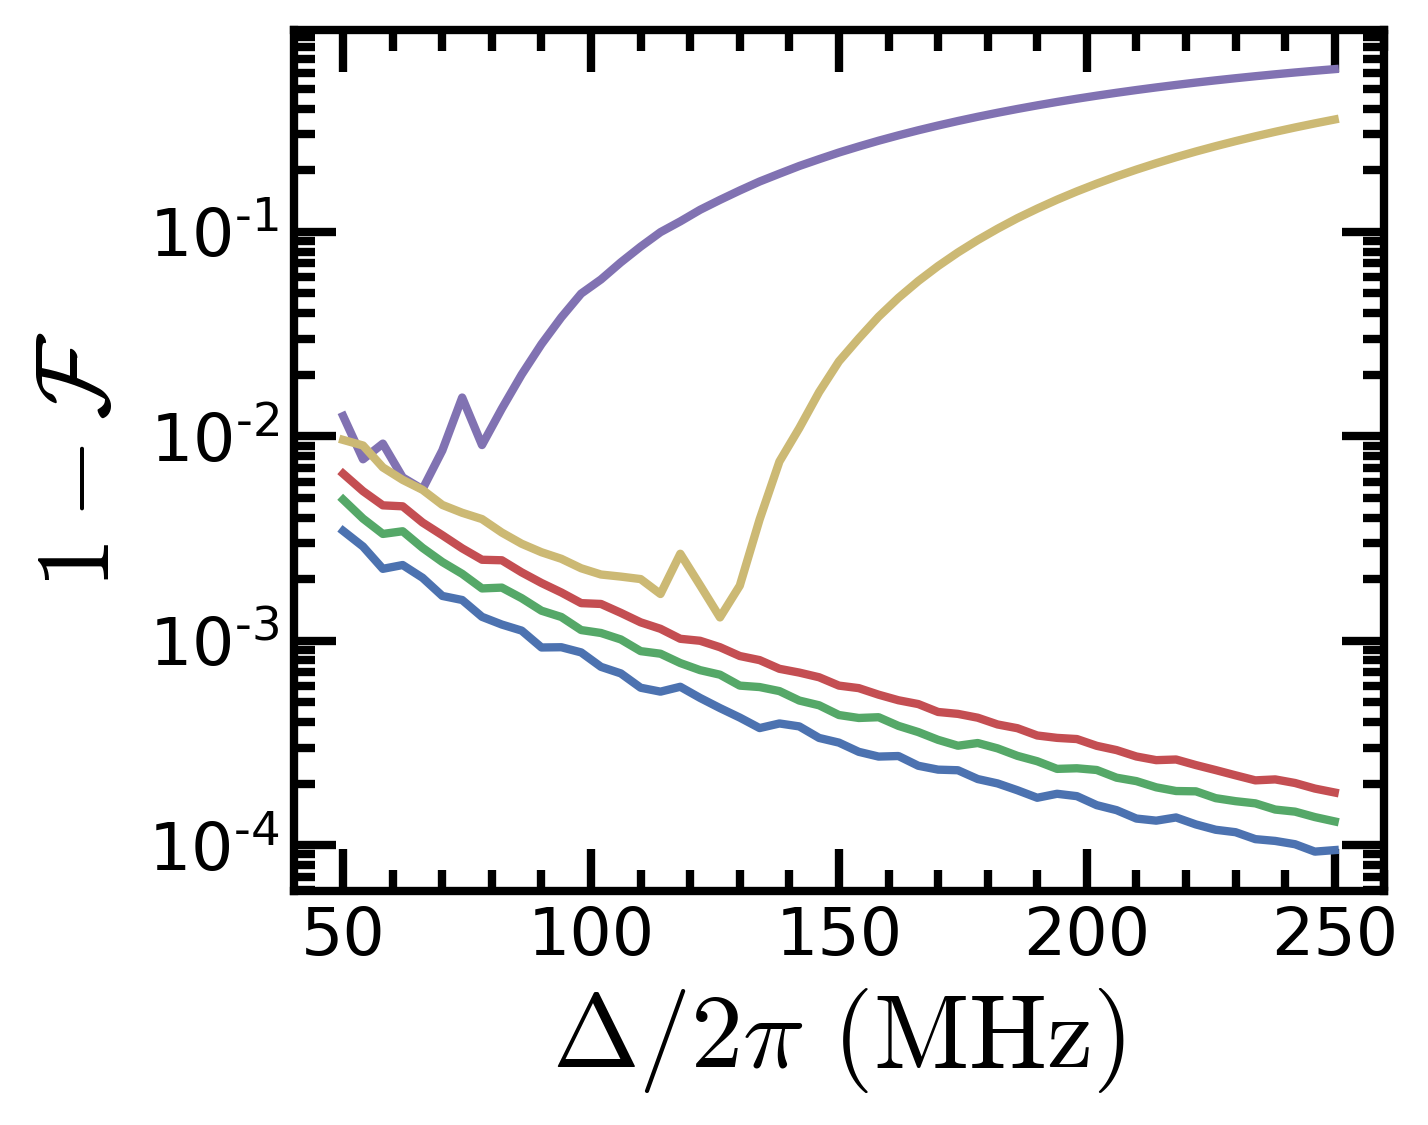

In [12]:
plt.figure(figsize = [5,4])
# plt.plot(detuning_array*1e3, infidelity_array[:,0], linewidth = 2, label = r'$J_C=1~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,1], linewidth = 2, label = r'$J_C=2~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,2], linewidth = 2, label = r'$J_C=3~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,3], linewidth = 2, label = r'$J_C=4~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,4], linewidth = 2, label = r'$J_C=5~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,5], linewidth = 2, label = r'$J_C=6~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,6], linewidth = 2, label = r'$J_C=7~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,7], linewidth = 2, label = r'$J_C=8~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,8], linewidth = 2, label = r'$J_C=9~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,9], linewidth = 2, label = r'$J_C=10~\mathrm{MHz}$')

plt.yscale("log")
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
# plt.xlim([50,250])
# plt.ylim([5e-5,1e-2])
# plt.legend()
plt.tight_layout()
# figname = 'CR_gate5.pdf'
# plt.savefig(figpath+figname)

### Subplot

In [ ]:
#Gate parameters to sweep
qcoupling_array = np.linspace(2,10,171)*1e-3
detuning_array = np.linspace(50,250,5)*1e-3

#Qubit frequency
w1 = 0.4
infidelity_array = np.zeros((len(detuning_array),len(qcoupling_array)))
coupl_const_array = np.zeros((len(detuning_array),len(qcoupling_array)))
U_ideal = cnot()
T_start = 0
T_gate = 200
T_rise = 50
t_points = np.linspace(0, T_gate, 2*int(T_gate)+1)
drag = False

for j_idx, J in enumerate(qcoupling_array):
    for d_idx, detuning in enumerate (detuning_array):
        w2 = w1 + detuning
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[2] - eig_energies[0]
        
        def infidelity(x):
            coupl = x[0]
            drive_freq = eig_energies[2]-eig_energies[0]
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        coupl_guess = (400*detuning)*0.005/J
        x0 = [coupl_guess] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None, options ={'xtol': 1e-6,'ftol':1e-7})
        coupl_const_array[d_idx,j_idx] = xopt.x[0]
        infidelity_array [d_idx,j_idx] = infidelity(xopt.x)
np.save(figpath+'/CR_coupling_vs_fidelity_variedDetune_TLS.npy',infidelity_array)

In [ ]:
qcoupling_array = np.linspace(2,10,171)*1e-3
detuning_array = np.linspace(50,250,5)*1e-3
infidelity_array = np.load(figpath+'/CR_coupling_vs_fidelity_variedDetune_TLS.npy')
plt.figure(figsize = [5,4])
for idx in range(len(detuning_array)):
    plt.plot(qcoupling_array*1e3, infidelity_array [idx,:], linewidth = 1.5)
plt.yscale("log")    
plt.xlim([2,10])
plt.ylim([1e-5,1e-2])
plt.xticks([2,4,6,8,10])
# mpl.rcParams.update({'font.size': 14})
# plt.tick_params(length=1, width=0.5)
plt.xlabel(r"$J_\mathrm{eff}/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
plt.text(2.3,2e-3,r'$\Delta/2\pi=50~\mathrm{MHz}$',rotation = 17, fontsize = 12)
plt.text(6.5,7e-5,r'$\Delta/2\pi=250~\mathrm{MHz}$',rotation = 17, fontsize = 12)
plt.tight_layout()
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
# figname = 'CR_gate_sub2.pdf'
# plt.savefig(figpath+figname)

In [ ]:
#Gate parameters to sweep
qcoupling_array = np.linspace(2,10,171)*1e-3
detuning_array = np.linspace(50,250,5)*1e-3

#Qubit frequency
w1 = 0.4
infidelity_array = np.zeros((len(detuning_array),len(qcoupling_array)))
coupl_const_array = np.zeros((len(detuning_array),len(qcoupling_array)))
U_ideal = cnot()
T_start = 0
T_gate = 200
T_rise = 50
t_points = np.linspace(0, T_gate, 2*int(T_gate)+1)
drag = False

for j_idx, J in enumerate(qcoupling_array):
    for d_idx, detuning in enumerate (detuning_array):
        w2 = w1 + detuning
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        state_00 = eig_states[0]
        state_01 = eig_states[2]
        state_10 = eig_states[1]
        state_11 = eig_states[3]
        drive_freq = eig_energies[2] - eig_energies[0]
        
        def error(x):
            coupl = x[0]
            eta = 0
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI+eta*IX)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
            sx0 = expect(IX,U_t*state_00)
            sy0 = expect(IY,U_t*state_00)
            sz0 = expect(IZ,U_t*state_00)
            sx1 = expect(IX,U_t*state_10)
            sy1 = expect(IY,U_t*state_10)
            sz1 = expect(IZ,U_t*state_10)
            R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
            return 1.0 - R[-1]

        coupl_guess = (400*detuning)*0.005/J
        x0 = [coupl_guess]
        xopt = minimize(error, x0, method ='Powell', tol = None, options ={'xtol': 1e-6,'ftol':1e-7})
        coupl_const_array[d_idx,j_idx] = xopt.x[0]
        infidelity_array [d_idx,j_idx] = error(xopt.x)
np.save(figpath+'/CR_coupling_vs_R_variedDetune_TLS.npy',infidelity_array)

In [ ]:
qcoupling_array = np.linspace(2,10,171)*1e-3
detuning_array = np.linspace(50,250,5)*1e-3
infidelity_array = np.load(figpath+'/CR_coupling_vs_R_variedDetune_TLS.npy')
plt.figure(figsize = [5, 4])
for idx in range(len(detuning_array)):
    plt.plot(qcoupling_array*1e3, infidelity_array [idx,:], linewidth = 1.5)
plt.yscale("log")    
plt.xlim([2,10])
plt.ylim([1e-5,1e-2])
plt.xticks([2,4,6,8,10])
# mpl.rcParams.update({'font.size': 14})
# plt.tick_params(length=1, width=0.5)
plt.xlabel(r"$J_\mathrm{eff}/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{R}_\mathrm{max}$')
plt.text(2.3,3e-3,r'$\Delta/2\pi=50~\mathrm{MHz}$',rotation = 15, fontsize = 12)
plt.text(6.5,1.2e-4,r'$\Delta/2\pi=250~\mathrm{MHz}$',rotation = 15, fontsize = 12)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
plt.tight_layout()
# figname = 'CR_gate_sub1.pdf'
# plt.savefig(figpath+figname)